In [1]:
import tensorflow as tf
from matplotlib.colors import LogNorm
from tensorflow.contrib import rnn
from tensorflow.python.client import device_lib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import pickle
from IPython import display
from matplotlib.patches import Ellipse

import h5py
os.environ['TZ'] = 'US/Pacific'
time.tzset()

filename_start="data/DurSweepA_"
filename_start="data/DurSweep4usNoRabi_"
filename_start="data/DurSweep4usRabi_"
filename_start="data/LeighisNice/DispNoRabiTestX"
filename_start="data/LeighisNice/DispNoRabiTestY"
filename_start="data/LeighisNice/DispRabi"
filename_start="data/AllPreps/InsaneRabi_Prep"



livestream=False

logs_path = 'model/prediction_retrodiction/'
model_name="prediction_retrodiction_tomo_dropout_32HS_v2"

logs_path = 'model/prediction_retrodiction/'
init_model="prediction_retrodiction_tomo_dropout_32HS_v1"




print(tf.__version__)
#device_lib.list_local_devices()

1.4.0-rc1


In [2]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16534110058156657720, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13660231205299216859
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7971798992946377220
 physical_device_desc: "device: XLA_CPU device"]

# Loading functions

In [3]:
def data_loading(i,filename_start,N_time):
        
    filename=filename_start+str(i)+".h5"

    if livestream:        
        nextfilename=filename_start+str(i+1)+".h5"

    else:
        nextfilename=filename_start+str(i)+".h5"

        
    Isfile=os.path.isfile(nextfilename)
    

    
    while Isfile==False:
        
        print("waiting for file "+nextfilename)
        time.sleep(1)
        Isfile=os.path.isfile(nextfilename)
    else:
        with h5py.File(filename, 'r') as hf:
            HerData = np.array(hf.get('HerData'))
            TrajData = np.array(hf.get('TrajData'))
            ROData = np.array(hf.get('ROData'))

            HerData=HerData.reshape(-1,N_time,7)
            ROData=ROData.reshape(-1,N_time,7)
            TrajData = TrajData.reshape(-1,N_time,7,TrajData.shape[-1])

            print(filename+" loaded")

    return TrajData, HerData, ROData

In [4]:
def data_loading_prep(i,filename_start="test",N_time=10):
        
    filename=filename_start+str(i)+".h5"
    nextfilename=filename_start+str(i+1)+".h5"

    Isfile=os.path.isfile(nextfilename)
    

    
    while Isfile==False:
        
        print("waiting for file "+nextfilename)
        time.sleep(1)
        Isfile=os.path.isfile(nextfilename)
    else:
        with h5py.File(filename, 'r') as hf:
            HerData = np.array(hf.get('HerData'))
            TrajData = np.array(hf.get('TrajData'))
            ROData = np.array(hf.get('ROData'))

            HerData=HerData.reshape(-1,N_time,7)
            ROData=ROData.reshape(-1,N_time,7)
            TrajData = TrajData.reshape(-1,N_time,7,TrajData.shape[-1])

            print(filename+" loaded")

    return TrajData, HerData, ROData

In [5]:
def prepocessing_data(TrajData_raw,HerData,ROData,time_list,thresholds=[-0.005,-0.004,-0.00,0.023],nshift=6,n_wait=0):

    
    N_points=TrajData_raw.shape[-1]
    N_time=time_list.shape[0]
    
    HeraldThreshold=thresholds[0]
    RoGroundThreshold=thresholds[1]
    RoExcitedThreshold1=thresholds[2]
    RoExcitedThreshold2=thresholds[3]
    
    traj_var=0.0766908841029
    traj_mean=-0.0100334628366

    traj_var=0.01335*1.2
    traj_mean=-0.07#-0.0207-0.0015*3
  
    #Tomo=['Z','X','-X','Y','-Y','-Z','-Z']
    tomo_table=np.array([[0,0,1],[1,0,0],[-1,0,0],[0,1,0],[0,-1,0],[0,0,-1],[0,0,-1]])
    #tomo_table=np.array([[1,0,0],[0,1,0],[0,-1,0],[0,0,1],[0,0,-1],[-1,0,0],[-1,0,0]])

    
    TrajData=np.zeros(TrajData_raw.shape)
    TrajData_retro=np.zeros(TrajData_raw.shape)
    
    TrajData=TrajData_raw/np.sqrt(traj_var)-traj_mean
    TrajData_retro=TrajData_raw/np.sqrt(traj_var)-traj_mean

    
    #TrajData_retro=np.zeros(TrajData.shape)
    
    
    TrajData[:,:,:,N_points-nshift:]=0
    TrajData_retro[:,:,:,N_points-nshift:]=0


    for i in np.arange(N_time):
        TrajData[:,i,:,:(N_points-nshift-time_list[i])]=0
        TrajData[:,i,:,:]=np.roll(TrajData[:,i,:,:],-(N_points-nshift-time_list[i]),axis=-1)

        TrajData_retro[:,i,:,:(N_points-nshift-time_list[i])]=0
        TrajData_retro[:,i,:,:]=np.flip(np.roll(TrajData_retro[:,i,:,:],nshift),axis=-1)


    heralding=HerData<HeraldThreshold
    ground=np.logical_and(ROData<RoGroundThreshold,heralding)
    excited=np.logical_and(np.logical_and(ROData>RoExcitedThreshold1,ROData<RoExcitedThreshold2),heralding)

    onehot=np.array([[0,1],[0,0],[1,0]])

    tomo_tile=np.tile(tomo_table,(TrajData.shape[0],N_time,1,1))
    label_ground=onehot[1+tomo_tile[ground]]
    label_excited=onehot[1-tomo_tile[excited]]
    
    time_indices=(np.array([time_list+n_wait]*7)).T
    time_tile=np.tile([time_indices],(TrajData.shape[0],1,1))
    time_ground=time_tile[ground]
    time_excited=time_tile[excited]


    label=np.concatenate([label_ground,label_excited])
    traj=np.concatenate([TrajData[ground],TrajData[excited]])
    traj_retro=np.concatenate([TrajData_retro[ground],TrajData_retro[excited]])
    sequence_time=np.concatenate([time_ground,time_excited])

    index=np.random.permutation(np.arange(traj.shape[0]))

    label=label[index]
    traj=traj[index]
    traj_retro=traj_retro[index]
    sequence_time=sequence_time[index]
    
    
    return traj,traj_retro,label,sequence_time

In [6]:
#Preparations=["Ground","Pio4","Pio2","3Pio4","Pi","5Pio4","3Pio2","7Pio4","Pio2ZeroPhase","Pio2PiPhase"]

#Tomo=['Z','X','-X','Y','-Y','-Z','-Z']
#tomo_table=np.array([[0,0,1],[1,0,0],[-1,0,0],[0,1,0],[0,-1,0],[0,0,-1],[0,0,-1]])



def load_prepdata(i,N_file,time_list,thresholds,n_wait,nshift,shuffledata,filename_start,file_list,plothist,plotgraphs):

    N_time=time_list.shape[0]
    PreparationClifford=["Ground","Pio2","Pi","3Pio2","Pio2ZeroPhase","Pio2PiPhase"]
    prep=(np.array([[0,0,1],[0,-1,0],[0,0,-1],[0,1,0],[-1,0,0],[1,0,0]])+1.)/2.

    #PreparationClifford=["Ground","Pio4","Pio2","3Pio4","Pi","5Pio4","3Pio2","7Pio4","Pio2ZeroPhase","Pio2PiPhase"]
    #prep=(np.array([[0,0,1],[0,-np.sqrt(2.)/2.,np.sqrt(2.)/2.],[0,-1,0],[0,-np.sqrt(2.)/2.,-np.sqrt(2.)/2.],[0,0,-1],[0,np.sqrt(2.)/2.,-np.sqrt(2.)/2.],[0,1,0],[0,np.sqrt(2.)/2.,np.sqrt(2.)/2.],[-1,0,0],[1,0,0]])+1.)/2.

    
    #PreparationClifford=["Pi"]
    #prep=(np.array([[0,0,1]])+1.)/2.


    N_time=20
    eval_data=[]
    eval_data_retro=[]
    eval_labels=[]
    eval_time=[]
    eval_prep=[]
    TrajData=[]
    HerData=[]
    ROData=[]
    
    for i in np.arange(i,i+N_file):
        for j in np.arange(prep.shape[0]):
            TrajData_tmp, HerData_tmp, ROData_tmp=data_loading_prep(file_list[i],filename_start+PreparationClifford[j],N_time=N_time)
            eval_data_tmp,eval_data_retro_tmp,eval_labels_tmp,eval_time_tmp = prepocessing_data(TrajData_tmp, HerData_tmp, ROData_tmp,time_list,thresholds,nshift=nshift, n_wait=n_wait)
            eval_prep_tmp=np.tile([prep[j]],[eval_data_tmp.shape[0],1])

            eval_data.append(eval_data_tmp)
            eval_data_retro.append(eval_data_retro_tmp)
            eval_labels.append(eval_labels_tmp)
            eval_time.append(eval_time_tmp)
            eval_prep.append(eval_prep_tmp)

            TrajData.append(TrajData_tmp)
            HerData.append(HerData_tmp)
            ROData.append(ROData_tmp)

    TrajData=np.concatenate(TrajData)
    HerData=np.concatenate(HerData)
    ROData=np.concatenate(ROData)
    prep=np.concatenate(prep)
        
    
    eval_data=np.concatenate(eval_data)
    eval_data_retro=np.concatenate(eval_data_retro)

    eval_labels=np.concatenate(eval_labels)
    eval_time=np.concatenate(eval_time)
    eval_prep=np.concatenate(eval_prep)
    
    index=np.random.permutation(np.arange(eval_data.shape[0]))
    eval_data=eval_data[index]
    eval_data_retro=eval_data_retro[index]
    eval_labels=eval_labels[index]
    eval_time=eval_time[index]
    eval_prep=eval_prep[index]
    
    
    
    if plothist:
        
        plt.figure()
        dataH=(HerData.flatten())
        plt.hist(dataH, bins=45, range=(-0.4,0.4))
        plt.axvline(x=HeraldThreshold, ymin=0, ymax=1)

        plt.figure()
        dataRO=(ROData.flatten())
        plt.hist(dataRO, bins=45, range=(-0.4,0.4))
        plt.axvline(x=RoGroundThreshold, ymin=0, ymax=1)
        plt.axvline(x=RoExcitedThreshold1, ymin=0, ymax=1)
        plt.axvline(x=RoExcitedThreshold2, ymin=0, ymax=1)

        
    if plotgraphs:

        n_steps = eval_data.shape[1]
        i=time_list[j]

        np.logical_and(eval_labels[:,2,1]==1,eval_time==i)

        plt.figure()
        
        plt.plot(eval_data[np.logical_and(eval_labels[:,2,1]==1,eval_time==i+n_wait)].mean(0))
        plt.plot(eval_data[np.logical_and(eval_labels[:,2,0]==1,eval_time==i+n_wait)].mean(0))
        plt.plot(eval_data[np.logical_and(eval_labels[:,1,1]==1,eval_time==i+n_wait)].mean(0))
        plt.plot(eval_data[np.logical_and(eval_labels[:,1,0]==1,eval_time==i+n_wait)].mean(0))
        plt.plot(eval_data[np.logical_and(eval_labels[:,0,1]==1,eval_time==i+n_wait)].mean(0))
        plt.plot(eval_data[np.logical_and(eval_labels[:,0,0]==1,eval_time==i+n_wait)].mean(0)) 


        plot_eval_data=eval_data*np.sqrt(0.07)-0.02
        j=0
        for j in np.arange(1,N_time,2):
            i=time_list[j]
            #print(i)
            #print(eval_data[eval_time==i].shape)
            plt.figure()
            plt.plot(plot_eval_data[eval_time==i+n_wait].mean(0))
            plt.plot((TrajData[:,j,:,n_steps-6-i:].mean(0)).mean(0))
            plt.plot((TrajData[:,j,:,:].mean(0)).mean(0))
            plt.axvline(i)
            plt.axvline(n_steps-nshift-i)

        plt.figure()
        for j in np.arange(1,N_time,2):

            k=time_list[j]+n_wait
            plt.plot(eval_data[eval_time==k].mean(0),'-o')
            plt.axvline(k)

        plt.figure()
        for j in np.arange(1,N_time,2):

            k=time_list[j]+n_wait
            plt.plot(eval_data[eval_time==k].var(0),'-o')
            plt.axvline(k)
            #plt.axvline(n_steps-i)
    
    
    return eval_data,eval_data_retro,eval_labels,eval_time,eval_prep

In [7]:
def loadingsim(numTest=30000):

    #lstTrajFileNames='simulatedTraj_RabiDriveV4_2.0MHz_Gamma1.0MHz_eta1.0_run0.0.p'
    #lstTrajFileNames='simulatedTraj_RabiDriveV4_2.0MHz_Gamma1.0MHz_eta0.5_run0.0.p'

    lstTrajFileNames='simulatedTraj_RabiDriveV4_2.0MHz_Gamma1.0MHz_eta0.5_run0.p'


    
    #vslot, xlabel, xbloch, ylabel, ybloch, zlabel, zbloch = None, None, None, None, None, None, None
    #with open(lstTrajFileNames, 'r') as f: # first file
    vslot, xlabel, xbloch, ylabel, ybloch, zlabel, zbloch = pickle.load(open(lstTrajFileNames, "rb"))


    meas_time=vslot.shape[0]

    traj = (vslot.T)[:,:meas_time]
    traj=(traj-traj.mean())/np.sqrt(traj.var())
    Vm = traj.mean(axis=1)

    sequence_length=(np.floor(np.random.uniform(size=(xbloch.shape[1]))*(xbloch.shape[0]-1))+1).astype(int)

    measX=np.array([xlabel[sequence_length[i],i] for i in np.arange(xbloch.shape[1])])
    measY=np.array([ylabel[sequence_length[i],i] for i in np.arange(xbloch.shape[1])])
    measZ=np.array([zlabel[sequence_length[i],i] for i in np.arange(xbloch.shape[1])])

    actualX=np.array([xbloch[sequence_length[i],i] for i in np.arange(xbloch.shape[1])])
    actualY=np.array([ybloch[sequence_length[i],i] for i in np.arange(xbloch.shape[1])])
    actualZ=np.array([zbloch[sequence_length[i],i] for i in np.arange(xbloch.shape[1])])


    #split into test and train
    Ntot=np.int(traj.shape[0]/3*3)#90000

    numTrain=Ntot-numTest

    onehot=np.array([[0,1],[1,0]])
    index_X=((measX+1)/2).astype(dtype='int')
    index_Y=((measY+1)/2).astype(dtype='int')
    index_Z=((measZ+1)/2).astype(dtype='int')

    labels_X=onehot[index_X].astype(dtype='float32')
    labels_Y=onehot[index_Y].astype(dtype='float32')
    labels_Z=onehot[index_Z].astype(dtype='float32')

    labels_X[1::3]=0*labels_X[1::3]
    labels_X[2::3]=0*labels_X[2::3]
    labels_Y[0::3]=0*labels_X[0::3]
    labels_Y[2::3]=0*labels_X[2::3]
    labels_Z[0::3]=0*labels_X[0::3]
    labels_Z[1::3]=0*labels_X[1::3]
    label_tot=np.stack([labels_X,labels_Y,labels_Z],axis=1)

    actual_X=((actualX+1)/2.).astype(dtype='float32')
    actual_Y=((actualY+1)/2.).astype(dtype='float32')
    actual_Z=((actualZ+1)/2.).astype(dtype='float32')
    actual=np.stack([np.stack([actual_X,1-actual_X],axis=1),np.stack([actual_Y,1-actual_Y],axis=1),np.stack([actual_Z,1-actual_Z],axis=1)],axis=1)


    train_data=traj[:numTrain]
    train_labels=label_tot[:numTrain].astype(dtype='int')
    train_actual=actual[:numTrain]
    train_time=sequence_length[:numTrain]+1

    eval_data=traj[numTrain:]
    eval_labels=label_tot[numTrain:].astype(dtype='int')
    eval_actual=actual[numTrain:]
    eval_time=sequence_length[numTrain:]+1

    return train_data,train_labels,train_time,eval_data,eval_labels,eval_time

In [8]:
def accuracy_retro(traj_t, test_label, N=11):

    tx_RO=traj_t[:,0]
    ty_RO=traj_t[:,1]
    tz_RO=traj_t[:,2]

    delta=1./N
    target=np.linspace(delta/2.,1.-delta/2.,N)


    num_x=np.zeros(N)
    num_z=np.zeros(N)
    x_tot=np.zeros((N,3))
    y_tot=np.zeros((N,3))
    z_tot=np.zeros((N,3))

    for i in np.arange(N):

        mask_array_x=np.logical_and((tx_RO>target[i]-delta/2.),(tx_RO<target[i]+delta/2.))
        mask_array_y=np.logical_and((ty_RO>target[i]-delta/2.),(ty_RO<target[i]+delta/2.))
        mask_array_z=np.logical_and((tz_RO>target[i]-delta/2.),(tz_RO<target[i]+delta/2.))

        labeltest = test_label[:,:,0]

        num_x=1.*mask_array_x.sum()
        num_y=1.*mask_array_y.sum()
        num_z=1.*mask_array_z.sum()

        if num_x==0:
            num_x=1.
        if num_y==0:
            num_y=1.
        if num_z==0:
            num_z=1.
        
        x_tomo=(1.*labeltest[mask_array_x][:,0]).mean()
        y_tomo=(1.*labeltest[mask_array_y][:,1]).mean()
        z_tomo=(1.*labeltest[mask_array_z][:,2]).mean()

        x_tot[i]=target[i], x_tomo, num_x
        y_tot[i]=target[i], y_tomo, num_y
        z_tot[i]=target[i], z_tomo, num_z


    x_tot=x_tot[x_tot[:,2]>20]
    y_tot=y_tot[y_tot[:,2]>20]
    z_tot=z_tot[z_tot[:,2]>20]

    x_error=np.sqrt(np.sum((x_tot[:,0]-x_tot[:,1])**2*x_tot[:,2])/x_tot[:,2].sum())
    y_error=np.sqrt(np.sum((y_tot[:,0]-y_tot[:,1])**2*y_tot[:,2])/y_tot[:,2].sum())
    z_error=np.sqrt(np.sum((z_tot[:,0]-z_tot[:,1])**2*z_tot[:,2])/z_tot[:,2].sum())

    return np.array([x_error,y_error,z_error]),x_tot,y_tot,z_tot


In [9]:
def accuracy_tomo(traj_t, test_label, N=11):

    tx_RO=traj_t[:,0]
    ty_RO=traj_t[:,1]
    tz_RO=traj_t[:,2]

    delta=1./N
    target=np.linspace(delta/2.,1.-delta/2.,N)


    num_x=np.zeros(N)
    num_z=np.zeros(N)
    x_tot=np.zeros((N,3))
    y_tot=np.zeros((N,3))
    z_tot=np.zeros((N,3))

    for i in np.arange(N):

        mask_array_x=np.logical_and((tx_RO>target[i]-delta/2.),(tx_RO<target[i]+delta/2.))
        mask_array_y=np.logical_and((ty_RO>target[i]-delta/2.),(ty_RO<target[i]+delta/2.))
        mask_array_z=np.logical_and((tz_RO>target[i]-delta/2.),(tz_RO<target[i]+delta/2.))

        labeltest=(test_label[:,:,0]-test_label[:,:,1])

        num_x=1.*np.abs(labeltest[mask_array_x][:,0]).sum()
        num_y=1.*np.abs(labeltest[mask_array_y][:,1]).sum()
        num_z=1.*np.abs(labeltest[mask_array_z][:,2]).sum()

        if num_x==0:
            num_x=1.
        if num_y==0:
            num_y=1.
        if num_z==0:
            num_z=1.
        
        x_tomo=((1.*labeltest[mask_array_x][:,0]).sum()/num_x+1.)/2.
        y_tomo=((1.*labeltest[mask_array_y][:,1]).sum()/num_y+1.)/2.
        z_tomo=((1.*labeltest[mask_array_z][:,2]).sum()/num_z+1.)/2.

        x_tot[i]=target[i], x_tomo, num_x
        y_tot[i]=target[i], y_tomo, num_y
        z_tot[i]=target[i], z_tomo, num_z


    x_tot=x_tot[x_tot[:,2]>20]
    y_tot=y_tot[y_tot[:,2]>20]
    z_tot=z_tot[z_tot[:,2]>20]

    x_error=np.sqrt(np.sum((x_tot[:,0]-x_tot[:,1])**2*x_tot[:,2])/x_tot[:,2].sum())
    y_error=np.sqrt(np.sum((y_tot[:,0]-y_tot[:,1])**2*y_tot[:,2])/y_tot[:,2].sum())
    z_error=np.sqrt(np.sum((z_tot[:,0]-z_tot[:,1])**2*z_tot[:,2])/z_tot[:,2].sum())

    return np.array([x_error,y_error,z_error]),x_tot,y_tot,z_tot


In [10]:
def accuracy_traj(actualtraj,traj_t, test_label, test_time,  delta):

    

    
    tx_RO=traj_t[:,0]
    ty_RO=traj_t[:,1]
    tz_RO=traj_t[:,2]


    
    N=time_list.shape[0]
    
    num_x=np.zeros(N)
    num_z=np.zeros(N)
    x_tot=np.zeros((N,3))
    y_tot=np.zeros((N,3))
    z_tot=np.zeros((N,3))

    for i in np.arange(N):

        mask_array_x=(tx_RO>actualtraj[i,0]-delta/2.)*(tx_RO<actualtraj[i,0]+delta/2.)*(test_time==time_list[i]+n_wait)

        mask_array_y=(ty_RO>actualtraj[i,1]-delta/2.)*(ty_RO<actualtraj[i,1]+delta/2.)*(test_time==time_list[i]+n_wait)
        mask_array_z=(tz_RO>actualtraj[i,2]-delta/2.)*(tz_RO<actualtraj[i,2]+delta/2.)*(test_time==time_list[i]+n_wait)

        labeltest=(test_label[:,:,0]-test_label[:,:,1])

        num_x=1.*np.abs(labeltest[mask_array_x][:,0]).sum()
        num_y=1.*np.abs(labeltest[mask_array_y][:,1]).sum()
        num_z=1.*np.abs(labeltest[mask_array_z][:,2]).sum()

        if num_x==0:
            num_x=1.
        if num_y==0:
            num_y=1.
        if num_z==0:
            num_z=1.
        
        x_tomo=((1.*labeltest[mask_array_x][:,0]).sum()/num_x+1.)/2.
        y_tomo=((1.*labeltest[mask_array_y][:,1]).sum()/num_y+1.)/2.
        z_tomo=((1.*labeltest[mask_array_z][:,2]).sum()/num_z+1.)/2.

        x_tot[i]=actualtraj[i,0], x_tomo, num_x
        y_tot[i]=actualtraj[i,1], y_tomo, num_y
        z_tot[i]=actualtraj[i,2], z_tomo, num_z


    x_tot=x_tot[x_tot[:,2]>20]
    y_tot=y_tot[y_tot[:,2]>20]
    z_tot=z_tot[z_tot[:,2]>20]

    x_error=np.sqrt(np.sum((x_tot[:,0]-x_tot[:,1])**2*x_tot[:,2])/x_tot[:,2].sum())
    y_error=np.sqrt(np.sum((y_tot[:,0]-y_tot[:,1])**2*y_tot[:,2])/y_tot[:,2].sum())
    z_error=np.sqrt(np.sum((z_tot[:,0]-z_tot[:,1])**2*z_tot[:,2])/z_tot[:,2].sum())

    return np.array([x_error,y_error,z_error]),x_tot,y_tot,z_tot


In [11]:
def get_traj(test_data,test_label,test_time,test_rho,batch_size):

    traj_tomo=[]
    loss=[]
    step=1
    while (step-1) * batch_size < test_data.shape[0]:

        if step * batch_size < test_data.shape[0]:
            batch_x=test_data[(step-1) * batch_size : step * batch_size]
            batch_y=test_label[(step-1) * batch_size : step * batch_size]
            batch_t=test_time[(step-1) * batch_size : step * batch_size]
            batch_rho=test_rho[(step-1) * batch_size : step * batch_size]
        else:
            batch_x=test_data[(step-1) * batch_size:]
            batch_y=test_label[(step-1) * batch_size:]
            batch_t=test_time[(step-1) * batch_size:]
            batch_rho=test_rho[(step-1) * batch_size:]
        
        traj_tomo_tmp,loss_tmp=sess.run([pred,cost_pred],feed_dict={
                                                                        x_pred: batch_x,
                                                                        y_pred: batch_y,
                                                                        t_pred:batch_t,
                                                                        rho_pred:batch_rho,
                                                                        x_retro: batch_x,
                                                                        y_retro: batch_y,
                                                                        t_retro:batch_t,
                                                                        rho_retro:batch_rho})
    
    
        
        traj_tomo.append(traj_tomo_tmp)
        loss.append(loss_tmp)
        step=step+1

    traj_tomo=np.concatenate(traj_tomo)
    loss_mean=np.array(loss).mean()
    
    return traj_tomo, loss_mean
    

In [12]:
def mixed_state_generator(eval_data_retro,eval_labels_retro,eval_time,eval_prep_retro, n_mixed=6):

    n_mixed=9

    data=[]
    prep=[]
    time=[]
    label=[]
    prep_actual=[]

    for j in np.arange(3):

        mask_up=(eval_prep_retro[:,j]==1)
        mask_down=(eval_prep_retro[:,j]==0)

        N_traj=min(eval_data_retro[mask_up].shape[0],eval_data_retro[mask_down].shape[0])//n_mixed//(n_mixed-1)*n_mixed*(n_mixed-1)

        data_u=np.split(eval_data_retro[mask_up][:N_traj],n_mixed)
        data_d=np.split(eval_data_retro[mask_down][:N_traj],n_mixed)

        labels_u=np.split(eval_labels_retro[mask_up][:N_traj],n_mixed)
        labels_d=np.split(eval_labels_retro[mask_down][:N_traj],n_mixed)

        prep_u=np.split(eval_prep_retro[mask_up][:N_traj],n_mixed)
        prep_d=np.split(eval_prep_retro[mask_down][:N_traj],n_mixed)

        time_u=np.split(eval_time[mask_up][:N_traj],n_mixed)
        time_d=np.split(eval_time[mask_down][:N_traj],n_mixed)


        Nindex=np.linspace(0,N_traj//n_mixed,n_mixed,dtype=int)

        for i in np.arange(n_mixed):


            data_mixed_1=np.concatenate([data_u[i][:Nindex[i]],data_d[i][Nindex[i]:]])
            data_mixed_2=np.concatenate([data_u[i][Nindex[i]:],data_d[i][:Nindex[i]]])

            labels_mixed_1=np.concatenate([labels_u[i][:Nindex[i]],labels_d[i][Nindex[i]:]])
            labels_mixed_2=np.concatenate([labels_u[i][Nindex[i]:],labels_d[i][:Nindex[i]]])

            time_mixed_1=np.concatenate([time_u[i][:Nindex[i]],time_d[i][Nindex[i]:]])
            time_mixed_2=np.concatenate([time_u[i][Nindex[i]:],time_d[i][:Nindex[i]]])

            prep_mixed_1=np.concatenate([prep_u[i][:Nindex[i]],prep_d[i][Nindex[i]:]])*0+np.concatenate([prep_u[i][:Nindex[i]],prep_d[i][Nindex[i]:]]).mean(0)
            prep_mixed_2=np.concatenate([prep_u[i][Nindex[i]:],prep_d[i][:Nindex[i]]])*0+np.concatenate([prep_u[i][Nindex[i]:],prep_d[i][:Nindex[i]]]).mean(0)

            prep_actual_1=np.concatenate([prep_u[i][:Nindex[i]],prep_d[i][Nindex[i]:]])
            prep_actual_2=np.concatenate([prep_u[i][Nindex[i]:],prep_d[i][:Nindex[i]]])
            
            
            data.append(data_mixed_1)
            data.append(data_mixed_2)

            time.append(time_mixed_1)
            time.append(time_mixed_2)

            prep.append(prep_mixed_1)
            prep.append(prep_mixed_2)
            
            prep_actual.append(prep_actual_1)
            prep_actual.append(prep_actual_2)

            label.append(labels_mixed_1)
            label.append(labels_mixed_2)

    data=np.concatenate(data)
    time=np.concatenate(time)
    prep=np.concatenate(prep)
    label=np.concatenate(label)
    prep_actual=np.concatenate(prep_actual)

    index=np.random.permutation(np.arange(data.shape[0]))

    data=data[index]
    time=time[index]
    label=label[index]
    prep=prep[index]

    return data,label,time,prep,prep_actual

In [13]:
def get_traj_pred_retro(data_pred, label_pred, time_pred, data_rho_pred,
             data_retro,label_retro,time_retro,data_rho_retro,batch_size):

    traj_pred=[]
    traj_retro=[]
    loss_pred=[]
    loss_retro=[]
    step=1
    while (step-1) * batch_size < min(data_pred.shape[0],data_retro.shape[0]):

        if step * batch_size < min(data_pred.shape[0],data_retro.shape[0]):

            batch_x_pred=data_pred[(step-1) * batch_size:step * batch_size]
            batch_y_pred=label_pred[(step-1) * batch_size:step * batch_size]
            batch_t_pred=time_pred[(step-1) * batch_size:step * batch_size]
            batch_rho_pred=data_rho_pred[(step-1) * batch_size:step * batch_size]

            batch_x_retro=data_retro[(step-1) * batch_size:step * batch_size]
            batch_y_retro=label_retro[(step-1) * batch_size:step * batch_size]
            batch_t_retro=time_retro[(step-1) * batch_size:step * batch_size]
            batch_rho_retro=data_rho_retro[(step-1) * batch_size:step * batch_size]

        else:
            
            batch_x_pred=data_pred[(step-1) * batch_size:]
            batch_y_pred=label_pred[(step-1) * batch_size:]
            batch_t_pred=time_pred[(step-1) * batch_size:]
            batch_rho_pred=data_rho_pred[(step-1) * batch_size:]

            batch_x_retro=data_retro[(step-1) * batch_size:]
            batch_y_retro=label_retro[(step-1) * batch_size:]
            batch_t_retro=time_retro[(step-1) * batch_size:]
            batch_rho_retro=data_rho_retro[(step-1) * batch_size:]
        
        
        traj_pred_tmp,traj_retro_tmp,loss_pred_tmp,loss_retro_tmp=sess.run([rho_final_pred,rho_final_retro,cost_pred,cost_retro],feed_dict={
                                                                                x: batch_x_pred,
                                                                                t: batch_t_pred,
                                                                                y_pred: batch_y_pred,
                                                                                rho_pred: batch_rho_pred,
                                                                                y_retro: batch_y_retro,
                                                                                rho_retro: batch_rho_retro,
                                                                                dropout: 0.})
        
        
        
        
        traj_pred.append(traj_pred_tmp)
        traj_retro.append(traj_retro_tmp)
        loss_pred.append(loss_pred_tmp)
        loss_retro.append(loss_retro_tmp)
        step=step+1

    traj_pred=np.concatenate(traj_pred)
    traj_retro=np.concatenate(traj_retro)

    loss_pred_mean=np.array(loss_pred).mean()
    loss_retro_mean=np.array(loss_retro).mean()
    
    return traj_pred, traj_retro, loss_pred_mean, loss_retro_mean
    #return batch_x_retro,batch_y_retro,batch_t_retro,batch_rho_retro

In [14]:
def get_traj_op(eval_op,data_pred, label_pred, time_pred, data_rho_pred,
             data_retro,label_retro,time_retro,data_rho_retro,batch_size):

    traj=[]
    
    step=1
    while (step-1) * batch_size < min(data_pred.shape[0],data_retro.shape[0]):

        if step * batch_size < min(data_pred.shape[0],data_retro.shape[0]):

            batch_x=data_pred[(step-1) * batch_size:step * batch_size]
            batch_t=time_pred[(step-1) * batch_size:step * batch_size]

            batch_y_pred=label_pred[(step-1) * batch_size:step * batch_size]
            batch_rho_pred=data_rho_pred[(step-1) * batch_size:step * batch_size]

            batch_y_retro=label_retro[(step-1) * batch_size:step * batch_size]
            batch_rho_retro=data_rho_retro[(step-1) * batch_size:step * batch_size]

        else:
            
            batch_x=data_pred[(step-1) * batch_size:]
            batch_t=time_pred[(step-1) * batch_size:]

            batch_y_pred=label_pred[(step-1) * batch_size:]
            batch_rho_pred=data_rho_pred[(step-1) * batch_size:]

            batch_y_retro=label_retro[(step-1) * batch_size:]
            batch_rho_retro=data_rho_retro[(step-1) * batch_size:]
        
        
        traj_tmp=sess.run(eval_op,feed_dict={
                                                                                x: batch_x,
                                                                                t: batch_t,
                                                                                y_pred: batch_y_pred,
                                                                                rho_pred: batch_rho_pred,
                                                                                y_retro: batch_y_retro,
                                                                                rho_retro: batch_rho_retro,
                                                                                dropout:0.})
        
        
        
        
        traj.append(traj_tmp)
        
        step=step+1
        #print(traj_tmp.shape)


    traj=np.concatenate(traj)
    return traj
    #return batch_x_retro,batch_y_retro,batch_t_retro,batch_rho_retro

In [15]:
def last_relevant(output, length):
    batch_size = tf.shape(output)[0]
    max_length = tf.shape(output)[1]
    out_size = int(output.get_shape()[2])
    index = tf.range(0, batch_size) * max_length + (length - 1)
    flat = tf.reshape(output, [-1, out_size])
    relevant = tf.gather(flat, index)
    return relevant

In [16]:
def convert_retro(eval_labels,eval_prep):

    eval_prep_retro=((eval_labels[:,:,0]+eval_labels[:,:,1])==0)*0.5+eval_labels[:,:,0]
    #eval_labels_retro=np.stack([(eval_prep*2-1>0)*eval_prep,(eval_prep*2-1<0)*eval_prep],axis=-1)
    eval_labels_retro=np.stack([(eval_prep!=0.5)*eval_prep,(eval_prep!=0.5)*(1-eval_prep)],axis=-1)

    return eval_labels_retro,eval_prep_retro

In [17]:
def plot_report(iter_tot,x_tot,y_tot,z_tot,error_tot,error_totX,error_totY,error_totZ,
               traj_tomo,
               loss_tot,loss_training_tot,entropy):

    fig = plt.figure(figsize=(15, 8))
    ax1 = fig.add_subplot(2,4,1)
    ax1.errorbar(x_tot[:,0], x_tot[:,1], yerr=np.sqrt(x_tot[:,1]*(1.-x_tot[:,1])/x_tot[:,2]), xerr=None, fmt='o')
    ax1.plot(np.linspace(0,1,10),np.linspace(0,1,10))
    ax1.set_aspect('equal')
    ax2 = fig.add_subplot(2,4,2)
    ax2.errorbar(y_tot[:,0], y_tot[:,1], yerr=np.sqrt(y_tot[:,1]*(1.-y_tot[:,1])/y_tot[:,2]), xerr=None, fmt='o')
    ax2.plot(np.linspace(0,1,10),np.linspace(0,1,10))
    ax2.set_aspect('equal')
    ax3 = fig.add_subplot(2,4,3)
    ax3.errorbar(z_tot[:,0], z_tot[:,1], yerr=np.sqrt(z_tot[:,1]*(1.-z_tot[:,1])/z_tot[:,2]), xerr=None, fmt='o')
    ax3.plot(np.linspace(0,1,10),np.linspace(0,1,10))
    ax3.set_aspect('equal')
    ax4 = fig.add_subplot(2,4,4)
    ax4.semilogy(iter_tot,error_tot)
    ax4.semilogy(iter_tot,error_totX)
    ax4.semilogy(iter_tot,error_totY)
    ax4.semilogy(iter_tot,error_totZ)
    ax4.semilogy(iter_tot,LR_tot,color='black')
    ax4.set_ylim([0.001,0.5])

    Nbin=31
    ax = fig.add_subplot(2,4,5)
    ax.add_artist(plt.Circle((0.5, 0.5), 0.5, color='red', fill=False))
    plt.hist2d(traj_tomo[:,1], traj_tomo[:,2],bins=np.linspace(0,1,Nbin),norm=LogNorm())
    ax.set_aspect('equal')

    ax = fig.add_subplot(2,4,6)
    ax.add_artist(plt.Circle((0.5, 0.5), 0.5, color='red', fill=False))
    plt.hist2d(traj_tomo[:,0], traj_tomo[:,2],bins=np.linspace(0,1,Nbin),norm=LogNorm())
    ax.set_aspect('equal')

    ax = fig.add_subplot(2,4,7)
    ax.add_artist(plt.Circle((0.5, 0.5), 0.5, color='red', fill=False))
    plt.hist2d(traj_tomo[:,0], traj_tomo[:,1],bins=np.linspace(0,1,Nbin),norm=LogNorm())
    ax.set_aspect('equal')


    ax4 = fig.add_subplot(2,4,8)
    plt.plot(iter_tot,loss_tot,color='black')
    plt.plot(iter_tot,loss_training_tot,color='blue')
    plt.plot(iter_tot,entropy,color='green')

# Loading evaluation data

data/AllPreps/InsaneRabi_PrepGround0.h5 loaded
data/AllPreps/InsaneRabi_PrepPio20.h5 loaded
data/AllPreps/InsaneRabi_PrepPi0.h5 loaded
data/AllPreps/InsaneRabi_Prep3Pio20.h5 loaded
data/AllPreps/InsaneRabi_PrepPio2ZeroPhase0.h5 loaded
data/AllPreps/InsaneRabi_PrepPio2PiPhase0.h5 loaded
data/AllPreps/InsaneRabi_PrepGround1.h5 loaded
data/AllPreps/InsaneRabi_PrepPio21.h5 loaded
data/AllPreps/InsaneRabi_PrepPi1.h5 loaded
data/AllPreps/InsaneRabi_Prep3Pio21.h5 loaded
data/AllPreps/InsaneRabi_PrepPio2ZeroPhase1.h5 loaded
data/AllPreps/InsaneRabi_PrepPio2PiPhase1.h5 loaded


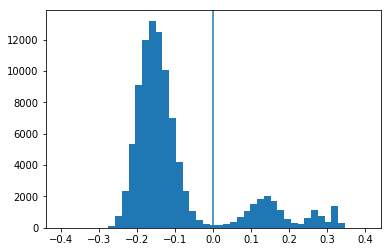

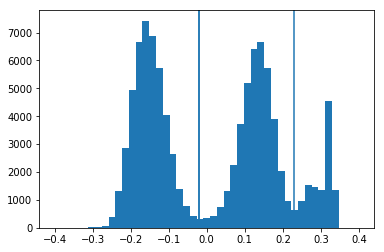

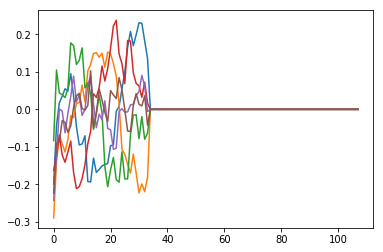

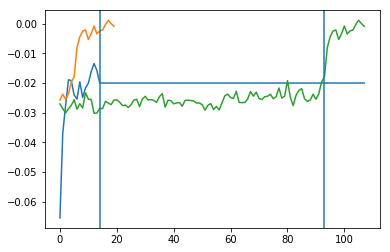

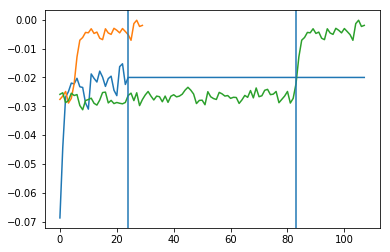

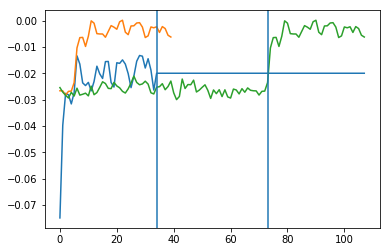

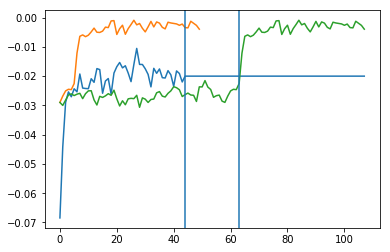

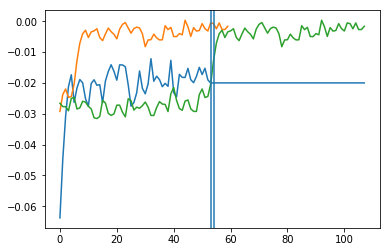

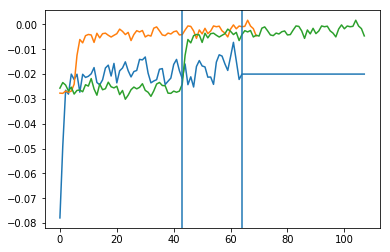

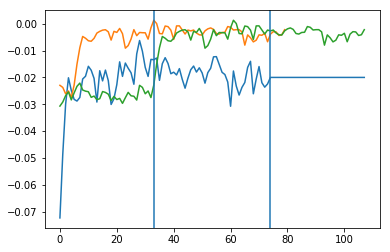

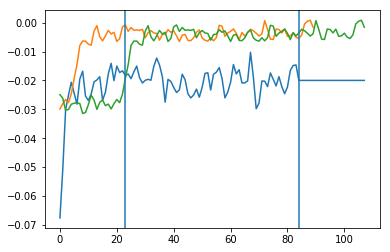

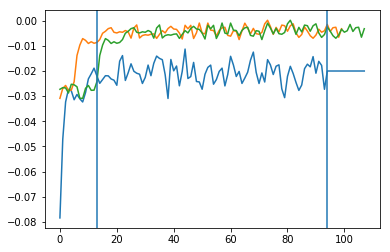

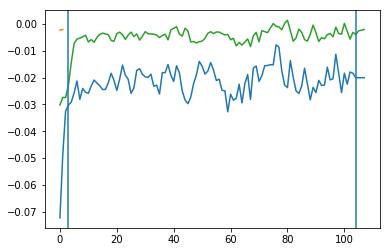

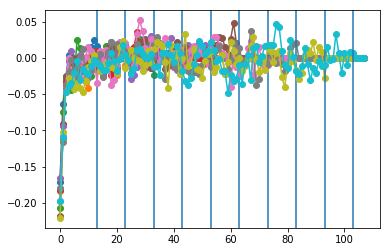

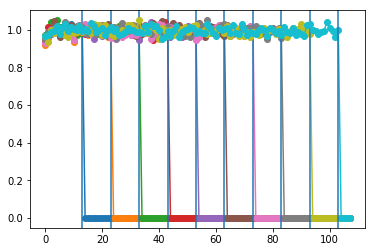

In [18]:
experimental_data=True

if experimental_data:

    
    n_offset=4

    
    Nfile_tot=49
    N_time=20
    time_list=(np.linspace(200,4000,N_time)/40-2).astype(int)
    time_list=(np.linspace(200,4000,N_time)/40+n_offset).astype(int)

    display_file=2
    
    n_wait=-1
    nshift=2
    nshift=1

    file_list=np.arange(0,Nfile_tot)

    
    shuffledata=True
    Neval=2
    HeraldThreshold=0.0
    RoGroundThreshold=-0.02
    RoExcitedThreshold1=-0.02
    RoExcitedThreshold2=0.23
    thresholds=[HeraldThreshold,RoGroundThreshold,RoExcitedThreshold1,RoExcitedThreshold2]

    #eval_data,eval_labels,eval_time,TrajData,file_list=load_evaldata(time_list,thresholds,Neval,n_wait,nshift,shuffledata,filename_start,file_list)
    plothist=True
    plotgraphs=True
    eval_data,eval_data_retro,eval_labels,eval_time,eval_prep = load_prepdata(0,Neval,time_list,thresholds,n_wait,nshift,shuffledata,filename_start,file_list,plothist,plotgraphs)
    eval_labels_retro,eval_prep_retro=convert_retro(eval_labels,eval_prep)
    

else:
    train_data,train_labels,train_time,eval_data,eval_labels,eval_time=loadingsim()
    time_list=np.arange(np.min(eval_time),np.max(eval_time)+1)
    n_wait=0
    N_time=time_list.shape[0]
    TrajData=eval_data
    n_steps=eval_data.shape[1]
    Neval=49


# Define Neural Network and PlaceHolder

In [19]:
# Network Parameters
n_hidden = 32 #64 #32 # hidden layer num of features
n_layer = 1 #3

n_input = 1 # MNIST data input (img shape: 28*28)
n_steps = eval_data.shape[1]#112 #58 #traj.shape[1] # timesteps
n_classes = 2 # Z_class (0-9 digits)
n_axis = 3 # Z_class (0-9 digits)


#training_iters = numTrain
training_epochs=3 
batch_size = 1024 #512 #1024 #256


# tf Graph input

x=tf.placeholder("float32", [None, n_steps,1])

y_pred = tf.placeholder("float32", [None, n_axis,n_classes])
rho_pred=tf.placeholder("float32", [None, n_axis])

y_retro = tf.placeholder("float32", [None, n_axis,n_classes])
rho_retro=tf.placeholder("float32", [None, n_axis])

t = tf.placeholder("int32", [None])

dropout=tf.placeholder("float32")



with tf.variable_scope("bi_rnn") as scope:

    intial_state_variable_c_fw = tf.get_variable("initial_state_retro_c_fw",[n_layer, 1 ,1, n_hidden], initializer=tf.zeros_initializer())
    intial_state_variable_h_fw = tf.get_variable("initial_state_retro_h_fw",[n_layer, 1 ,1, n_hidden-n_axis], initializer=tf.zeros_initializer())
     
    h_rho_fw=tf.tile(tf.reshape(rho_pred,[1,1,-1,n_axis]),[n_layer,1,1,1])
    h_var_fw=tf.tile(intial_state_variable_h_fw,[1,1,tf.shape(x)[0],1])
    h_fw=tf.concat([h_rho_fw,h_var_fw],axis=3)
    c_fw=tf.tile(intial_state_variable_c_fw,[1,1,tf.shape(x)[0],1])
    intial_state_variable_fw_batch=tf.concat([c_fw,h_fw],axis=1)
    l_fw = tf.unstack(intial_state_variable_fw_batch, axis=0)
    rnn_tuple_state_fw = tuple(
     [tf.contrib.rnn.LSTMStateTuple(l_fw[idx][0],l_fw[idx][1])
      for idx in range(n_layer)])

    
    intial_state_variable_c_bw = tf.get_variable("initial_state_retro_c_bw",[n_layer, 1 ,1, n_hidden], initializer=tf.zeros_initializer())
    intial_state_variable_h_bw = tf.get_variable("initial_state_retro_h_bw",[n_layer, 1 ,1, n_hidden-n_axis], initializer=tf.zeros_initializer())
    
    h_rho_bw=tf.tile(tf.reshape(rho_retro,[1,1,-1,n_axis]),[n_layer,1,1,1])
    h_var_bw=tf.tile(intial_state_variable_h_bw,[1,1,tf.shape(x)[0],1])
    h_bw=tf.concat([h_rho_bw,h_var_bw],axis=3)
    c_bw=tf.tile(intial_state_variable_c_bw,[1,1,tf.shape(x)[0],1])
    intial_state_variable_bw_batch=tf.concat([c_bw,h_bw],axis=1)
    l_bw = tf.unstack(intial_state_variable_bw_batch, axis=0)
    rnn_tuple_state_bw = tuple(
     [tf.contrib.rnn.LSTMStateTuple(l_bw[idx][0],l_bw[idx][1])
      for idx in range(n_layer)])

    
    cell_bw = tf.contrib.rnn.MultiRNNCell(
    [rnn.BasicLSTMCell(n_hidden, state_is_tuple=True) for _ in range(n_layer)],
    state_is_tuple=True)
    cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, input_keep_prob=1.0, output_keep_prob=1.0, state_keep_prob=1.-dropout)

    
    cell_fw = tf.contrib.rnn.MultiRNNCell(
    [rnn.BasicLSTMCell(n_hidden, state_is_tuple=True) for _ in range(n_layer)],
    state_is_tuple=True)
    cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, input_keep_prob=1.0, output_keep_prob=1.0, state_keep_prob=1.-dropout)



    outputs, states = tf.nn.bidirectional_dynamic_rnn(
                                                        cell_fw=cell_fw,
                                                        cell_bw=cell_bw,
                                                        inputs=x,
                                                        sequence_length=t,
                                                        initial_state_fw=rnn_tuple_state_fw,
                                                        initial_state_bw=rnn_tuple_state_bw,
                                                        dtype=tf.float32
                                                        )


    # Define weights
    weights_bw = tf.get_variable("weights_retro", [n_hidden, n_axis],
        initializer=tf.random_normal_initializer())

    biases_bw = tf.get_variable("biases_retro", [n_axis],
        initializer=tf.random_normal_initializer())

    # Define weights
    weights_fw = tf.get_variable("weights_pred", [n_hidden, n_axis],
        initializer=tf.random_normal_initializer())

    biases_fw = tf.get_variable("biases_pred", [n_axis],
        initializer=tf.random_normal_initializer())
    
    
    
    rho_final_pred=tf.nn.sigmoid(tf.matmul(last_relevant(outputs[0],t), weights_fw) + biases_fw)
    rho_init_pred =tf.nn.sigmoid(tf.matmul(outputs[0][:,n_offset], weights_fw) + biases_fw)

    identity_t=tf.ones([tf.shape(x)[0]],dtype="int32")

    #output_retro=tf.reverse_sequence(outputs[1],t)
    
    rho_init_retro =tf.nn.sigmoid(tf.matmul(last_relevant(outputs[1],t-n_offset*identity_t), weights_bw) + biases_bw)
    rho_final_retro=tf.nn.sigmoid(tf.matmul(outputs[1][:,0], weights_bw) + biases_bw)
    
    rho_traj_pred =tf.stack([tf.nn.sigmoid(tf.matmul(outputs[0][:,i], weights_fw) + biases_fw) for i in np.arange(n_offset,n_steps)],axis=1)
    
    output_retro=tf.reverse_sequence(outputs[1],t,batch_dim = 0,seq_dim = 1)
    rho_traj_retro_tmp=tf.stack([tf.nn.sigmoid(tf.matmul(output_retro[:,i], weights_bw) + biases_bw) for i in np.arange(n_offset,n_steps)],axis=1)
    rho_traj_retro=tf.reverse_sequence(rho_traj_retro_tmp,t-n_offset*identity_t,batch_dim = 0,seq_dim = 1)

    
    cost_init_pred=tf.reduce_mean(tf.square(rho_init_pred-rho_pred))
    cost_init_retro=tf.reduce_mean(tf.square(rho_init_retro-rho_retro))    
    
    #rho_traj_retro=tf.stack([tf.nn.sigmoid(tf.matmul(outputs[:,i], weights_fw) + biases) for i in np.arange(n_steps)],axis=1)

In [20]:
#rho_traj_retro=tf.reverse_sequence(rho_traj_retro_tmp,t-n_offset*identity_t,batch_dim = 0,seq_dim = 1)


# Define Tomography gradient search

In [20]:
identity=tf.ones([tf.shape(x)[0],n_axis])
  
#alpha_tomo = tf.Variable(tf.ones([1,n_axis]), trainable=True)
theta = tf.Variable(0., trainable=True)
phi= tf.Variable(0., trainable=True)
radius = tf.Variable(0., trainable=True)
purity_tomo=tf.tanh(radius)

#rho_init=tf.stack([[purity_tomo*tf.cos(theta)*tf.sin(phi),purity_tomo*tf.sin(theta)*tf.cos(phi),purity_tomo*tf.sin(phi)]])

rho_init=tf.stack([[purity_tomo*tf.cos(theta),purity_tomo*tf.sin(theta)*tf.cos(phi),purity_tomo*tf.sin(theta)*tf.sin(phi)]])


rho_tile=tf.tile(rho_init,[tf.shape(x)[0],1])
                              
cost_tomo=tf.reduce_mean(-tf.log(1/2.+1/2.*tf.reduce_sum((2*rho_final_retro-identity)*rho_tile,reduction_indices=[1])))




# Define loss and optimizer

In [21]:
# Define loss and optimizer

expdecay=False
powerdecay=False

identity=tf.ones([tf.shape(x)[0],n_axis])

regularization = tf.Variable(1., trainable=False)

cross_entropy_pred=tf.reduce_mean(-y_pred[:,:,0]*tf.log(rho_final_pred)-y_pred[:,:,1]*tf.log(identity-rho_final_pred))
cost_pred=cross_entropy_pred+regularization*cost_init_pred

cross_entropy_retro=tf.reduce_mean(-y_retro[:,:,0]*tf.log(rho_final_retro)-y_retro[:,:,1]*tf.log(identity-rho_final_retro))
cost_retro=cross_entropy_retro+regularization*cost_init_retro



iteration = tf.Variable(0, trainable=False)

if expdecay:
    
    learning_rate = tf.train.exponential_decay(0.02, iteration, 1, 1-0.5*10**(-5) )

    optimizer_pred = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_pred, global_step=iteration)
    optimizer_retro = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_retro, global_step=iteration)

else:
    #LR_init=0.002
    #LR_schedule=[0.001,0.0003,0.0001]
    LR_schedule=[0.01,0.003,0.001,0.0003,0.0001]

    learning_rate = tf.Variable(LR_schedule[0], trainable=False)
    optimizer_pred = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_pred, global_step=iteration)
    optimizer_retro = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_retro, global_step=iteration)

    optimizer_tomo = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_tomo, var_list=[theta,phi,radius], global_step=iteration)

# Evaluate model
accuracy=tf.Variable(0.0,trainable=False)

# Initializing the variables
init = tf.global_variables_initializer()


tf.summary.scalar("loss", cost_pred)
tf.summary.scalar("accuracy", accuracy)

merged_summary_op = tf.summary.merge_all()

/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# Run RNN training for prediction and retrodiction

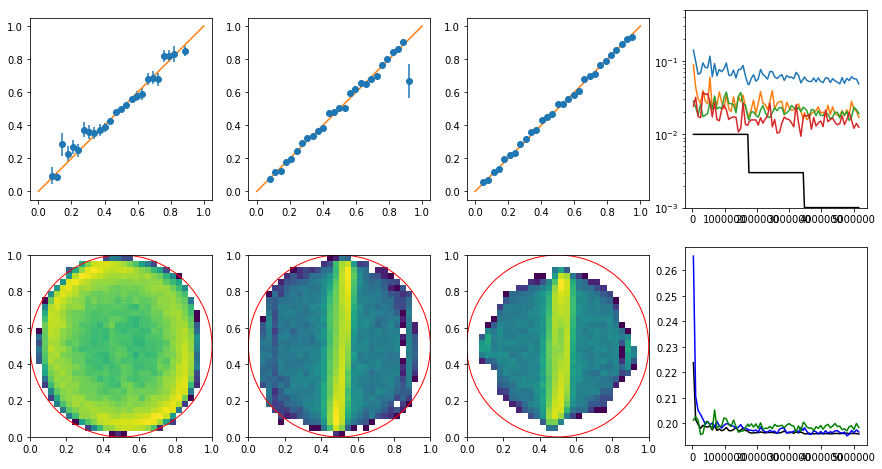

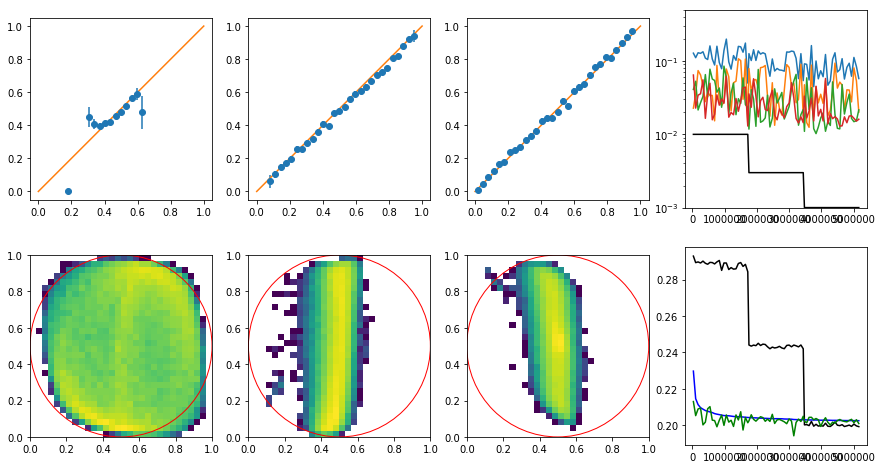

train time 324.960 eval time 105.170
time per iter 4.408 ms
Iter 5160962, Minibatch Loss= 0.195836, Training Accuracy= 0.048792
[ 0.01700456  0.01930811  0.01247911]
Learning Rate 0.001
46 loaded files on 47 - epoch 2
model_saved at iter 5087234
Model saved in file: model/prediction_retrodiction/prediction_retrodiction_tomo_dropout_32HS_v2
Model saved in file: model/prediction_retrodiction/prediction_retrodiction_tomo_dropout_32HS_v2
Optimization Finished!


In [22]:
# Launch the graph
saver = tf.train.Saver()
run=time.strftime("%Y%m%d") + '_' + time.strftime("%H%M%S")

start1 = time.clock()
training_iters=0
training_iters_timing=0
saving_iter=0

# Calculate accuracy for 128 mnist test images

#eval_labels,eval_prep = convert_retro(eval_labels,eval_prep)

test_data = eval_data.reshape((-1, n_steps, n_input))
test_label = eval_labels
test_time=eval_time
test_rho=eval_prep

test_data_retro = eval_data_retro.reshape((-1, n_steps, n_input))
test_time_retro=eval_time
test_label_retro,test_rho_retro = convert_retro(test_label,test_rho)


dropout_batch=0.3

#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
error_tot=[]
error_totX=[]
error_totY=[]
error_totZ=[]
loss_tot=[]
loss_regul_tot=[]
loss_cross_entropy_tot=[]
entropy=[]

error_tot_retro=[]
error_totX_retro=[]
error_totY_retro=[]
error_totZ_retro=[]
loss_tot_retro=[]
entropy_retro=[]

iter_tot=[]
LR_tot=[]
loss_training=[]
loss_training_tot=[]
loss_training_retro=[]
loss_training_retro_tot=[]

#LR_schedule=[0.01,0.003,0.001,0.001,0.0003,0.0003,0.0001]
#regularization_schedule=[1.,1.,1.,1.,0.5,0.00,0.00]

R_schedule=[0.001,0.0003,0.0001]
Dropout_schedule=[0.3,0.3,0.3]
regularization_schedule=[1.,.5,0.]


#LR_schedule=[0.001,0.001]
#Dropout_schedule=[0.3,0.00]


starting_model=False
restore_previous_model=False
shuffledata=True
generate_mixedstates_pred=False
generate_mixedstates_retro=False
loading_retro_pred=False


with tf.Session() as sess:
    
    sess.run(init)
    
    if loading_retro_pred:
        var_list= tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="rnn_prediction")
        saver_prediction = tf.train.Saver(var_list)

        var_list= tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="rnn_retrodiction")
        saver_retrodiction = tf.train.Saver(var_list)

        saver_prediction.restore(sess, logs_path+init_model)
        saver_retrodiction.restore(sess, logs_path+init_model)
    elif starting_model:
        saver.restore(sess, logs_path+init_model)
        print("Starting Model restored.")
    elif restore_previous_model:
        saver.restore(sess, logs_path+model_name)
        print("Model restored.")
    
    summary_writer = tf.summary.FileWriter('%s_James_is_nice_%s' % (logs_path, run), graph=tf.get_default_graph())
    
    # Keep training until reach max iterations
    
    for epoch in np.arange(training_epochs):
        
        dropout_batch=Dropout_schedule[epoch]
        sess.run(learning_rate.assign(LR_schedule[epoch]))
        sess.run(regularization.assign(regularization_schedule[epoch]))
        
        #if epoch%5==0:
        #    training_iters=0
        if shuffledata:
            file_list=np.random.permutation(file_list)
    

        for n_file in np.arange(Neval,Nfile_tot):

            step = 1

            train_data,_,train_labels,train_time,train_prep = load_prepdata(file_list[n_file],1,time_list,thresholds,n_wait,nshift,shuffledata,filename_start,file_list,plothist=False,plotgraphs=False)
            #train_time_retro=train_time
            train_labels_retro,train_prep_retro = convert_retro(train_labels,train_prep)

            if generate_mixedstates_pred:
                #train_data_retro,train_labels_retro,train_time_retro,train_prep_retro = mixed_state_generator(train_data_retro,train_labels_retro,train_time,train_prep_retro)
                
                train_data,train_labels,train_time,train_prep,train_prep_actual = mixed_state_generator(train_data,train_labels,train_time,train_prep)
                train_labels_retro,train_prep_retro = convert_retro(train_labels,train_prep_actual)
                
            if generate_mixedstates_retro:
                train_labels_retro,train_prep_retro = convert_retro(train_labels,train_prep_actual)
                train_data,train_labels_retro,train_time,train_prep_retro,train_prep_retro_actual = mixed_state_generator(train_data,train_labels_retro,train_time,train_prep_retro)
                train_labels,train_prep = convert_retro(train_labels_retro,train_prep_retro_actual)


            while step * batch_size < train_data.shape[0]:

                batch_x=train_data[(step-1) * batch_size:step * batch_size]
                batch_t=train_time[(step-1) * batch_size:step * batch_size]

                batch_y_pred=train_labels[(step-1) * batch_size:step * batch_size]
                batch_rho_pred=train_prep[(step-1) * batch_size:step * batch_size]
                
                batch_y_retro=train_labels_retro[(step-1) * batch_size:step * batch_size]
                batch_rho_retro=train_prep_retro[(step-1) * batch_size:step * batch_size]*0.+0.5

                #batch_t_retro=train_time_retro[(step-1) * batch_size:step * batch_size]

                
                training_iters += batch_x.shape[0]

                sess.run(iteration.assign(training_iters)) 

                # Reshape data to get 28 seq of 28 elements
                batch_x = batch_x.reshape((-1, n_steps, n_input))

                # Run optimization op (backprop)
                _,_,loss_tmp,loss_retro_tmp,summary=sess.run([optimizer_pred,optimizer_retro,cost_pred,cost_retro,merged_summary_op],feed_dict={
                                                                                x: batch_x,
                                                                                t: batch_t,
                                                                                y_pred: batch_y_pred,
                                                                                rho_pred: batch_rho_pred,
                                                                                y_retro: batch_y_retro,
                                                                                rho_retro: batch_rho_retro,
                                                                                dropout: dropout_batch
                                                                               })

                summary_writer.add_summary(summary, step * batch_size+n_file*training_iters)

                loss_training.append(loss_tmp)
                loss_training_retro.append(loss_retro_tmp)
                
                step += 1
                
                
            if n_file % display_file == 0:
                
                # Calculate batch accuracy
                stop1 = time.clock()
                training_iters_timing_diff=training_iters-training_iters_timing
                training_iters_timing=training_iters
                start = time.clock()

                #traj_tomo,loss,loss_cross_entropy,loss_regul=sess.run([pred,cost,cross_entropy,regul_smooth], feed_dict={x: test_data, y: test_label,t:test_time, rho:test_rho})
                #traj_tomo,loss=get_traj(test_data,test_label,test_time,test_rho,batch_size*2)

                traj_tomo,traj_retro,loss,loss_retro=get_traj_pred_retro(test_data, test_label, test_time, test_rho,
                                         test_data_retro,test_label_retro,test_time_retro,test_rho_retro,batch_size*4)


                error,x_tot,y_tot,z_tot=accuracy_tomo(traj_tomo, test_label,  N=31)
                acc=error.sum()

                error_retro,x_tot_retro,y_tot_retro,z_tot_retro=accuracy_tomo(traj_retro, test_label_retro,  N=31)
                acc_retro=error_retro.sum()


                sess.run(accuracy.assign(acc))
                LR=sess.run(learning_rate)

                iter_tot.append(training_iters)

                error_tot.append(acc)
                error_totX.append(error[0])
                error_totY.append(error[1])
                error_totZ.append(error[2])

                error_tot_retro.append(acc_retro)
                error_totX_retro.append(error_retro[0])
                error_totY_retro.append(error_retro[1])
                error_totZ_retro.append(error_retro[2])

                LR_tot.append(LR)
                loss_tot.append(loss)
                loss_tot_retro.append(loss_retro)

                entropy.append((-traj_tomo*np.log(traj_tomo)-(1-traj_tomo)*np.log(1-traj_tomo)).mean()/3.)    
                entropy_retro.append((-traj_retro*np.log(traj_retro)-(1-traj_retro)*np.log(1-traj_retro)).mean()/3.)    

                loss_training_mean=np.array(loss_training).mean()
                loss_training_retro_mean=np.array(loss_training_retro).mean()


                loss_training=[]
                loss_training_tot.append(loss_training_mean)
                loss_training_retro_tot.append(loss_training_retro_mean)


                plot_report(iter_tot,x_tot,y_tot,z_tot,error_tot,error_totX,error_totY,error_totZ,
                               traj_tomo,
                               loss_tot,loss_training_tot,entropy)

                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.gcf().clear()


                plot_report(iter_tot,x_tot_retro,y_tot_retro,z_tot_retro,error_tot_retro,error_totX_retro,error_totY_retro,error_totZ_retro,
                               traj_retro,
                               loss_tot_retro,loss_training_retro_tot,entropy_retro)


                display.display(plt.gcf())

                plt.gcf().clear()


                stop = time.clock()

                print("train time "+"{:.3f}".format(stop1-start1)+" eval time "+"{:.3f}".format(stop-start))
                print("time per iter "+"{:.3f}".format((stop1-start1)/training_iters_timing_diff*1000.)+" ms")

                # Calculate batch loss
                print( "Iter " + str(sess.run(iteration)) + \
                      ", Minibatch Loss= " + "{:.6f}".format(loss) + \
                      ", Training Accuracy= "+"{:.6f}".format(sess.run(accuracy)))
                print(error)
                print( "Learning Rate "+str(sess.run(learning_rate)))
                print( str(n_file-Neval)+" loaded files on "+str(Nfile_tot-Neval)+" - epoch "+str(epoch))

                print( "model_saved at iter "+str(saving_iter))

                saving_iter=sess.run(iteration)
                save_path = saver.save(sess, logs_path+model_name)
                print("Model saved in file: %s" % save_path)


                start1 = time.clock()



                
        saving_iter=sess.run(iteration)
        save_path = saver.save(sess, logs_path+model_name)
        print("Model saved in file: %s" % save_path)

                
    print ("Optimization Finished!")

# Run tomography from RNN training

In [23]:
Neval=10

train_data,train_data_retro,train_labels,train_time,train_prep = load_prepdata(0,Neval,time_list,thresholds,n_wait,nshift,shuffledata,filename_start,file_list,plothist=False,plotgraphs=False)
train_labels_retro,train_prep_retro = convert_retro(train_labels,train_prep)
train_time_retro=train_time

data/AllPreps/InsaneRabi_PrepGround28.h5 loaded
data/AllPreps/InsaneRabi_PrepPio228.h5 loaded
data/AllPreps/InsaneRabi_PrepPi28.h5 loaded
data/AllPreps/InsaneRabi_Prep3Pio228.h5 loaded
data/AllPreps/InsaneRabi_PrepPio2ZeroPhase28.h5 loaded
data/AllPreps/InsaneRabi_PrepPio2PiPhase28.h5 loaded
data/AllPreps/InsaneRabi_PrepGround43.h5 loaded
data/AllPreps/InsaneRabi_PrepPio243.h5 loaded
data/AllPreps/InsaneRabi_PrepPi43.h5 loaded
data/AllPreps/InsaneRabi_Prep3Pio243.h5 loaded
data/AllPreps/InsaneRabi_PrepPio2ZeroPhase43.h5 loaded
data/AllPreps/InsaneRabi_PrepPio2PiPhase43.h5 loaded
data/AllPreps/InsaneRabi_PrepGround37.h5 loaded
data/AllPreps/InsaneRabi_PrepPio237.h5 loaded
data/AllPreps/InsaneRabi_PrepPi37.h5 loaded
data/AllPreps/InsaneRabi_Prep3Pio237.h5 loaded
data/AllPreps/InsaneRabi_PrepPio2ZeroPhase37.h5 loaded
data/AllPreps/InsaneRabi_PrepPio2PiPhase37.h5 loaded
data/AllPreps/InsaneRabi_PrepGround9.h5 loaded
data/AllPreps/InsaneRabi_PrepPio29.h5 loaded
data/AllPreps/InsaneRabi_Prep

In [24]:
rho_tomo_final=[]
prep_final=[]

with tf.Session() as sess:
    
    sess.run(init)
    
    #var_list= tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="rnn_prediction")
    #saver_prediction = tf.train.Saver(var_list)

    #var_list= tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="rnn_retrodiction")
    saver = tf.train.Saver()

    saver.restore(sess, logs_path+init_model)
    #saver_retrodiction.restore(sess, logs_path+init_model)
    
    prep=(np.array([[0,0,1],[0,1,0],[0,0,-1],[0,-1,0],[1,0,0],[-1,0,0]])+1.)/2.
    
    for k in np.random.permutation(np.arange(prep.shape[0])):
    
        cost_tot=[]
        rho_tot=[]
    
        mask_time=(train_time>time_list[-10]-1)
        mask_prep=(np.zeros(train_prep.shape[0])==0)
        for i in np.arange(train_prep.shape[0]):
            mask_prep[i]=np.array_equal(train_prep[i],prep[k])
        mask=np.logical_and(mask_time,mask_prep)


        tomo_data=train_data[mask]
        tomo_labels=train_labels[mask]
        tomo_time=train_time[mask]
        tomo_prep=train_prep[mask]

        tomo_data_retro=train_data_retro[mask]
        tomo_labels_retro=train_labels_retro[mask]
        tomo_time_retro=train_time_retro[mask]
        tomo_prep_retro=train_prep_retro[mask]#*0.+0.5


        #theta = tf.Variable(np.random.normal(0, 1), trainable=True)
        #phi= tf.Variable(0., trainable=True)
        #purity_tomo = tf.Variable(0., trainable=True)

        
        
        sess.run(radius.assign(0.1))
        sess.run(theta.assign(2*np.pi*np.random.normal(0, 1)))
        sess.run(phi.assign(2*np.pi*np.random.normal(0, 1)))

        #alpha_tomo = tf.Variable(tf.ones([1,n_axis]), trainable=True)


        N_epoch=20


        for epoch in np.arange(N_epoch):

            LR=0.5/1.2**epoch
            #LR=0.05
            batch_size_tomo=256 #512#256
            
            sess.run(learning_rate.assign(LR))

            print(str(epoch)+" - "+str(LR))
            step = 1

            rho_init
            
            index=np.random.permutation(np.arange(tomo_data.shape[0]))

            tomo_data=tomo_data[index]
            tomo_labels=tomo_labels[index]
            tomo_time=tomo_time[index]
            tomo_prep=tomo_prep[index]

            tomo_data_retro=tomo_data_retro[index]
            tomo_labels_retro=tomo_labels_retro[index]
            tomo_time_retro=tomo_time_retro[index]
            tomo_prep_retro=tomo_prep_retro[index]

            while step * batch_size_tomo < min(tomo_prep_retro.shape[0],tomo_prep_retro.shape[0]):

                batch_x=tomo_data[(step-1) * batch_size_tomo:step * batch_size_tomo]
                batch_t=tomo_time[(step-1) * batch_size_tomo:step * batch_size_tomo]

                batch_y_pred=tomo_labels[(step-1) * batch_size_tomo:step * batch_size_tomo]
                batch_rho_pred=tomo_prep[(step-1) * batch_size_tomo:step * batch_size_tomo]

                batch_y_retro=tomo_labels_retro[(step-1) * batch_size_tomo:step * batch_size_tomo]
                batch_rho_retro=tomo_prep_retro[(step-1) * batch_size_tomo:step * batch_size_tomo]


                # Reshape data to get 28 seq of 28 elements
                batch_x = batch_x.reshape((-1, n_steps, n_input))


                # Run optimization op (backprop)
                _,cost,rho_test = sess.run([optimizer_tomo,cost_tomo,rho_init],feed_dict={
                                                                                x: batch_x,
                                                                                t: batch_t,
                                                                                y_pred: batch_y_pred,
                                                                                rho_pred: batch_rho_pred,
                                                                                y_retro: batch_y_retro,
                                                                                rho_retro: batch_rho_retro,
                                                                                dropout: 0.
                                                                               })


                cost_tot.append(cost)
                rho_tot.append(rho_test)

                #print(cost)
                #print(rho)

                step=step+1

        cost_tot=np.array(cost_tot)
        rho_tot=np.concatenate(rho_tot)

        plt.figure()
        plt.plot(cost_tot)

        plt.figure()
        plt.plot((rho_tot[:,0]+1)/2.,label='X')
        plt.plot((rho_tot[:,1]+1)/2.,label='Y')
        plt.plot((rho_tot[:,2]+1)/2.,label='Z')
        
        plt.plot((rho_tot**2).sum(-1),label='purity')

        plt.title(prep[k])
        plt.ylim([0,1])
        plt.legend()


        rho_tomo_final.append((rho_tot[-1,:]+1)/2.)
        prep_final.append((prep[k,:]+1)/2.)

        
prep_final = np.stack(prep_final)
rho_tomo_final = np.stack(rho_tomo_final)


a=rho_tomo_final
b=prep_final*2-1

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(a[:,1],a[:,2],'o')
plt.plot(b[:,1],b[:,2],'o')

plt.subplot(1,3,2)
plt.plot(a[:,0],a[:,1],'o')
plt.plot(b[:,0],b[:,1],'o')

plt.subplot(1,3,3)
plt.plot(a[:,0],a[:,2],'o')
plt.plot(b[:,0],b[:,2],'o')

INFO:tensorflow:Restoring parameters from model/prediction_retrodiction/prediction_retrodiction_tomo_dropout_32HS_v1


NotFoundError: Key bi_rnn/bidirectional_rnn/bw/multi_rnn_cell/cell_0/basic_lstm_cell/bias not found in checkpoint
	 [[Node: save_1/RestoreV2_25 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/RestoreV2_25/tensor_names, save_1/RestoreV2_25/shape_and_slices)]]

Caused by op 'save_1/RestoreV2_25', defined at:
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-75e696280e6c>", line 12, in <module>
    saver = tf.train.Saver()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1233, in __init__
    self.build()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1242, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1278, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 759, in _build_internal
    restore_sequentially, reshape)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 428, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 268, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1021, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3042, in create_op
    op_def=op_def)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1521, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key bi_rnn/bidirectional_rnn/bw/multi_rnn_cell/cell_0/basic_lstm_cell/bias not found in checkpoint
	 [[Node: save_1/RestoreV2_25 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/RestoreV2_25/tensor_names, save_1/RestoreV2_25/shape_and_slices)]]


In [29]:
import scipy.optimize as sp


rho_tomo_final=[]
prep_final=[]

#init_model="prediction_retrodiction_tomo_dropout_test_v6"


with tf.Session() as sess:
    
    sess.run(init)
    
    #var_list= tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="rnn_prediction")
    #saver_prediction = tf.train.Saver(var_list)

    #var_list= tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="rnn_retrodiction")
    saver = tf.train.Saver()

    saver.restore(sess, logs_path+init_model)
    #saver_retrodiction.restore(sess, logs_path+init_model)
    
    prep=(np.array([[0,0,1],[0,1,0],[0,0,-1],[0,-1,0],[1,0,0],[-1,0,0]])+1.)/2.
    
    for k in np.random.permutation(np.arange(prep.shape[0])):
    
        cost_tot=[]
        rho_tot=[]
        rho_retro_test=[]
    
        mask_time=(train_time>time_list[-10]-1)
        mask_prep=(np.zeros(train_prep.shape[0])==0)
        for i in np.arange(train_prep.shape[0]):
            mask_prep[i]=np.array_equal(train_prep[i],prep[k])
        mask=np.logical_and(mask_time,mask_prep)


        tomo_data=train_data[mask]
        tomo_labels=train_labels[mask]
        tomo_time=train_time[mask]
        tomo_prep=train_prep[mask]

        tomo_data_retro=train_data_retro[mask]
        tomo_labels_retro=train_labels_retro[mask]
        tomo_time_retro=train_time_retro[mask]
        tomo_prep_retro=train_prep_retro[mask]#*0.+0.5


        #theta = tf.Variable(np.random.normal(0, 1), trainable=True)
        #phi= tf.Variable(0., trainable=True)
        #purity_tomo = tf.Variable(0., trainable=True)

        
        
        sess.run(radius.assign(0.1))
        sess.run(theta.assign(2*np.pi*np.random.normal(0, 1)))
        sess.run(phi.assign(2*np.pi*np.random.normal(0, 1)))

        #alpha_tomo = tf.Variable(tf.ones([1,n_axis]), trainable=True)


     

          
        #LR=0.05
        batch_size_tomo=1024 #512#256


        step = 1

        rho_init

        index=np.random.permutation(np.arange(tomo_data.shape[0]))

        tomo_data=tomo_data[index]
        tomo_labels=tomo_labels[index]
        tomo_time=tomo_time[index]
        tomo_prep=tomo_prep[index]

        tomo_data_retro=tomo_data_retro[index]
        tomo_labels_retro=tomo_labels_retro[index]
        tomo_time_retro=tomo_time_retro[index]
        tomo_prep_retro=tomo_prep_retro[index]

        while step * batch_size_tomo < min(tomo_prep_retro.shape[0],tomo_prep_retro.shape[0]):

            batch_x=tomo_data[(step-1) * batch_size_tomo:step * batch_size_tomo]
            batch_t=tomo_time[(step-1) * batch_size_tomo:step * batch_size_tomo]

            batch_y_pred=tomo_labels[(step-1) * batch_size_tomo:step * batch_size_tomo]
            batch_rho_pred=tomo_prep[(step-1) * batch_size_tomo:step * batch_size_tomo]

            batch_y_retro=tomo_labels_retro[(step-1) * batch_size_tomo:step * batch_size_tomo]
            batch_rho_retro=tomo_prep_retro[(step-1) * batch_size_tomo:step * batch_size_tomo]*0+0.5


            # Reshape data to get 28 seq of 28 elements
            batch_x = batch_x.reshape((-1, n_steps, n_input))




            # Run optimization op (backprop)
            rho_final_retro_tmp = sess.run(rho_final_retro,feed_dict={ 
                                                                            x: batch_x,
                                                                            t: batch_t,
                                                                            y_pred: batch_y_pred,
                                                                            rho_pred: batch_rho_pred,
                                                                            y_retro: batch_y_retro,
                                                                            rho_retro: batch_rho_retro,
                                                                            dropout: 0.
                                                                           })


            rho_retro_test.append(rho_final_retro_tmp)

            #print(cost)
            #print(rho)

            step=step+1

        rho_retro_test=np.concatenate(rho_retro_test)


        def rho_from_polar(arg):
            purity_tomo=np.tanh(arg[0])
            theta=arg[1]
            phi=arg[2]

            #rho_tmp=purity_tomo*np.array([np.cos(theta),np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi)])
            rho_tmp=purity_tomo*np.array([0,np.cos(phi),np.sin(phi)])

            
            
            return rho_tmp
        
        

        def tomo_loss(arg):
            
            #rho_tmp=purity_tomo*np.array([np.cos(theta),np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi)])
            rho_tmp=rho_from_polar(arg)

            return -(np.log(1/2.+1/2.*((2.*rho_retro_test-1.)*rho_tmp).sum(-1))).mean()
            #return -((1/2.+1/2.*((2.*rho_retro_test-1.)*rho_tmp).sum(-1))).mean()

        #return -(np.log(1/2.+1/2.*(2*rho_retro_test-1)*rho_tmp)).sum()

        
        
        
        


        result=sp.minimize(tomo_loss, [0.01,0,0])


        print(tomo_prep_retro.shape[0])
        print(rho_from_polar(result['x']))
        print(prep[k,:])
        
        print(result)

        rho_tomo_final.append(rho_from_polar(result['x']))
        prep_final.append(prep[k,:])

        
prep_final = np.stack(prep_final)
rho_tomo_final = np.stack(rho_tomo_final)


b=rho_tomo_final
a=prep_final*2-1

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(a[:,1],a[:,2],'o')
plt.plot(b[:,1],b[:,2],'o')

plt.subplot(1,3,2)
plt.plot(a[:,0],a[:,1],'o')
plt.plot(b[:,0],b[:,1],'o')

plt.subplot(1,3,3)
plt.plot(a[:,0],a[:,2],'o')
plt.plot(b[:,0],b[:,2],'o')

INFO:tensorflow:Restoring parameters from model/prediction_retrodiction/prediction_retrodiction_tomo_dropout_32HS_v1


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for model/prediction_retrodiction/prediction_retrodiction_tomo_dropout_32HS_v1
	 [[Node: save_2/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_2/Const_0_0, save_2/RestoreV2/tensor_names, save_2/RestoreV2/shape_and_slices)]]

Caused by op 'save_2/RestoreV2', defined at:
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-efb98605650b>", line 18, in <module>
    saver = tf.train.Saver()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1233, in __init__
    self.build()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1242, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1278, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 759, in _build_internal
    restore_sequentially, reshape)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 428, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 268, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1021, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3042, in create_op
    op_def=op_def)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1521, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for model/prediction_retrodiction/prediction_retrodiction_tomo_dropout_32HS_v1
	 [[Node: save_2/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_2/Const_0_0, save_2/RestoreV2/tensor_names, save_2/RestoreV2/shape_and_slices)]]


In [ ]:
import scipy.optimize as sp
result=sp.minimize(tomo_loss, [0,0,0])
rho_from_polar(result['x'])

In [ ]:
identity=tf.ones([tf.shape(x)[0],n_axis])
  
#alpha_tomo = tf.Variable(tf.ones([1,n_axis]), trainable=True)
theta = tf.Variable(0., trainable=True)
phi= tf.Variable(0., trainable=True)
radius = tf.Variable(0., trainable=True)
purity_tomo=tf.tanh(radius)

#rho_init=tf.stack([[purity_tomo*tf.cos(theta)*tf.sin(phi),purity_tomo*tf.sin(theta)*tf.cos(phi),purity_tomo*tf.sin(phi)]])

rho_init=tf.stack([[purity_tomo*tf.cos(theta),purity_tomo*tf.sin(theta)*tf.cos(phi),purity_tomo*tf.sin(theta)*tf.sin(phi)]])


rho_tile=tf.tile(rho_init,[tf.shape(x)[0],1])
                              
cost_tomo=tf.reduce_mean(-tf.log(1/2.+1/2.*tf.reduce_sum((2*rho_final_retro-identity)*rho_tile,reduction_indices=[1])))



# Evaluation of the RNN training

In [25]:
with tf.Session() as sess:
    sess.run(init)
    
    #saver.restore(sess, logs_path+model_name)
    saver.restore(sess, logs_path+init_model)

    
    print("Model restored.")
    plothist=True
    plotgraphs=True
    Neval=8
    
    train_data,train_data_retro,train_labels,train_time,train_prep = load_prepdata(file_list[n_file],Neval,time_list,thresholds,n_wait,nshift,shuffledata,filename_start,file_list,plothist=False,plotgraphs=False)
    train_labels_retro,train_prep_retro = convert_retro(train_labels,train_prep)

    test_data = train_data.reshape((-1, n_steps, n_input))
    test_data_retro = train_data_retro.reshape((-1, n_steps, n_input))

    test_label = train_labels
    test_label_retro=train_labels_retro
    
    test_time=train_time
    test_time_retro=train_time
    
    test_rho=train_prep
    test_rho_retro=train_prep_retro
    
    traj_tomo,traj_retro,loss,loss_retro=get_traj_pred_retro(test_data, test_label, test_time, test_rho,
                                             test_data_retro,test_label_retro,test_time_retro,test_rho_retro,batch_size)

INFO:tensorflow:Restoring parameters from model/prediction_retrodiction/prediction_retrodiction_tomo_dropout_32HS_v1


NotFoundError: Key bi_rnn/bidirectional_rnn/bw/multi_rnn_cell/cell_0/basic_lstm_cell/kernel not found in checkpoint
	 [[Node: save_1/RestoreV2_28 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/RestoreV2_28/tensor_names, save_1/RestoreV2_28/shape_and_slices)]]

Caused by op 'save_1/RestoreV2_28', defined at:
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-75e696280e6c>", line 12, in <module>
    saver = tf.train.Saver()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1233, in __init__
    self.build()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1242, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1278, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 759, in _build_internal
    restore_sequentially, reshape)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 428, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 268, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1021, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3042, in create_op
    op_def=op_def)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1521, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key bi_rnn/bidirectional_rnn/bw/multi_rnn_cell/cell_0/basic_lstm_cell/kernel not found in checkpoint
	 [[Node: save_1/RestoreV2_28 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/RestoreV2_28/tensor_names, save_1/RestoreV2_28/shape_and_slices)]]


In [ ]:
traj_t=traj_tomo
test_label_time=test_label
error,x_tot,y_tot,z_tot=accuracy_tomo(traj_tomo, test_label_time,  N=31)

fig = plt.figure(figsize=(14, 4))
fig.suptitle(' acuracy total: '+"{:.2f}".format(error.sum()*100)+"%")

ax1 = fig.add_subplot(141)
ax1.errorbar(x_tot[:,0], x_tot[:,1], yerr=np.sqrt(x_tot[:,1]*(1.-x_tot[:,1])/x_tot[:,2]), xerr=None, fmt='o')
ax1.plot(np.linspace(0,1,10),np.linspace(0,1,10))
ax1.set_aspect('equal')
ax1.set_title("acuracy X: "+"{:.2f}".format(error[0]*100)+"%")

ax2 = fig.add_subplot(142)
ax2.errorbar(y_tot[:,0], y_tot[:,1], yerr=np.sqrt(y_tot[:,1]*(1.-y_tot[:,1])/y_tot[:,2]), xerr=None, fmt='o')
ax2.plot(np.linspace(0,1,10),np.linspace(0,1,10))
ax2.set_aspect('equal')
ax2.set_title("acuracy Y: "+"{:.2f}".format(error[1]*100)+"%")


ax3 = fig.add_subplot(143)
ax3.errorbar(z_tot[:,0], z_tot[:,1], yerr=np.sqrt(z_tot[:,1]*(1.-z_tot[:,1])/z_tot[:,2]), xerr=None, fmt='o')
ax3.plot(np.linspace(0,1,10),np.linspace(0,1,10))
ax3.set_aspect('equal')
ax3.set_title("acuracy Z: "+"{:.2f}".format(error[2]*100)+"%")

for j in np.arange(N_time):
    maskarray_time=(test_time==time_list[j]+n_wait)
    traj_tomo_time=traj_t[maskarray_time]
    test_label_time=test_label[maskarray_time]

    error,x_tot,y_tot,z_tot=accuracy_tomo(traj_tomo_time, test_label_time,  N=31)

    fig = plt.figure(figsize=(14, 4))
    fig.suptitle(' time:'+str(time_list[j])+' acuracy total: '+"{:.2f}".format(error.sum()*100)+"%")

    
    ax1 = fig.add_subplot(141)
    ax1.errorbar(x_tot[:,0], x_tot[:,1], yerr=np.sqrt(x_tot[:,1]*(1.-x_tot[:,1])/x_tot[:,2]), xerr=None, fmt='o')
    ax1.plot(np.linspace(0,1,10),np.linspace(0,1,10))
    ax1.set_aspect('equal')
    ax1.set_title("acuracy X: "+"{:.2f}".format(error[0]*100)+"%")
    
    ax2 = fig.add_subplot(142)
    ax2.errorbar(y_tot[:,0], y_tot[:,1], yerr=np.sqrt(y_tot[:,1]*(1.-y_tot[:,1])/y_tot[:,2]), xerr=None, fmt='o')
    ax2.plot(np.linspace(0,1,10),np.linspace(0,1,10))
    ax2.set_aspect('equal')
    ax2.set_title("acuracy Y: "+"{:.2f}".format(error[1]*100)+"%")

    
    ax3 = fig.add_subplot(143)
    ax3.errorbar(z_tot[:,0], z_tot[:,1], yerr=np.sqrt(z_tot[:,1]*(1.-z_tot[:,1])/z_tot[:,2]), xerr=None, fmt='o')
    ax3.plot(np.linspace(0,1,10),np.linspace(0,1,10))
    ax3.set_aspect('equal')
    ax3.set_title("acuracy Z: "+"{:.2f}".format(error[2]*100)+"%")

In [ ]:
traj_t=traj_retro
test_label_time=test_label_retro
error,x_tot,y_tot,z_tot=accuracy_tomo(traj_t, test_label_time,  N=31)

fig = plt.figure(figsize=(14, 4))
fig.suptitle(' acuracy total: '+"{:.2f}".format(error.sum()*100)+"%")

ax1 = fig.add_subplot(141)
ax1.errorbar(x_tot[:,0], x_tot[:,1], yerr=np.sqrt(x_tot[:,1]*(1.-x_tot[:,1])/x_tot[:,2]), xerr=None, fmt='o')
ax1.plot(np.linspace(0,1,10),np.linspace(0,1,10))
ax1.set_aspect('equal')
ax1.set_title("acuracy X: "+"{:.2f}".format(error[0]*100)+"%")

ax2 = fig.add_subplot(142)
ax2.errorbar(y_tot[:,0], y_tot[:,1], yerr=np.sqrt(y_tot[:,1]*(1.-y_tot[:,1])/y_tot[:,2]), xerr=None, fmt='o')
ax2.plot(np.linspace(0,1,10),np.linspace(0,1,10))
ax2.set_aspect('equal')
ax2.set_title("acuracy Y: "+"{:.2f}".format(error[1]*100)+"%")


ax3 = fig.add_subplot(143)
ax3.errorbar(z_tot[:,0], z_tot[:,1], yerr=np.sqrt(z_tot[:,1]*(1.-z_tot[:,1])/z_tot[:,2]), xerr=None, fmt='o')
ax3.plot(np.linspace(0,1,10),np.linspace(0,1,10))
ax3.set_aspect('equal')
ax3.set_title("acuracy Z: "+"{:.2f}".format(error[2]*100)+"%")

for j in np.arange(N_time):
    maskarray_time=(test_time==time_list[j]+n_wait)
    traj_t_time=traj_t[maskarray_time]
    test_label_time=test_label_retro[maskarray_time]

    error,x_tot,y_tot,z_tot=accuracy_tomo(traj_t_time, test_label_time,  N=31)

    fig = plt.figure(figsize=(14, 4))
    fig.suptitle(' time:'+str(time_list[j])+' acuracy total: '+"{:.2f}".format(error.sum()*100)+"%")

    
    ax1 = fig.add_subplot(141)
    ax1.errorbar(x_tot[:,0], x_tot[:,1], yerr=np.sqrt(x_tot[:,1]*(1.-x_tot[:,1])/x_tot[:,2]), xerr=None, fmt='o')
    ax1.plot(np.linspace(0,1,10),np.linspace(0,1,10))
    ax1.set_aspect('equal')
    ax1.set_title("acuracy X: "+"{:.2f}".format(error[0]*100)+"%")
    
    ax2 = fig.add_subplot(142)
    ax2.errorbar(y_tot[:,0], y_tot[:,1], yerr=np.sqrt(y_tot[:,1]*(1.-y_tot[:,1])/y_tot[:,2]), xerr=None, fmt='o')
    ax2.plot(np.linspace(0,1,10),np.linspace(0,1,10))
    ax2.set_aspect('equal')
    ax2.set_title("acuracy Y: "+"{:.2f}".format(error[1]*100)+"%")

    
    ax3 = fig.add_subplot(143)
    ax3.errorbar(z_tot[:,0], z_tot[:,1], yerr=np.sqrt(z_tot[:,1]*(1.-z_tot[:,1])/z_tot[:,2]), xerr=None, fmt='o')
    ax3.plot(np.linspace(0,1,10),np.linspace(0,1,10))
    ax3.set_aspect('equal')
    ax3.set_title("acuracy Z: "+"{:.2f}".format(error[2]*100)+"%")

In [ ]:
traj_t=traj_tomo
traj_time=traj_t[test_time!=time_list[0]+n_wait]
Nbin=61
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,3,1)
ax.add_artist(plt.Circle((0.5, 0.5), 0.5, color='red', fill=False))
plt.hist2d(traj_time[:,1], traj_time[:,2],bins=np.linspace(0,1,Nbin),norm=LogNorm())
ax.set_aspect('equal')

ax = fig.add_subplot(1,3,2)
ax.add_artist(plt.Circle((0.5, 0.5), 0.5, color='red', fill=False))
plt.hist2d(traj_time[:,0], traj_time[:,2],bins=np.linspace(0,1,Nbin),norm=LogNorm())
ax.set_aspect('equal')

ax = fig.add_subplot(1,3,3)
ax.add_artist(plt.Circle((0.5, 0.5), 0.5, color='red', fill=False))
plt.hist2d(traj_time[:,0], traj_time[:,1],bins=np.linspace(0,1,Nbin),norm=LogNorm())
ax.set_aspect('equal')

for i in np.arange(1,20):
    traj_time=traj_t[test_time==time_list[i]+n_wait]

    fig=plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,3,1)
    ax.add_artist(plt.Circle((0.5, 0.5), 0.5, color='white', fill=False))
    plt.hist2d(traj_time[:,1], traj_time[:,2],bins=np.linspace(0,1,70),norm=LogNorm())
    ax.set_aspect('equal')

    ax = fig.add_subplot(1,3,2)
    ax.add_artist(plt.Circle((0.5, 0.5), 0.5, color='white', fill=False))
    plt.hist2d(traj_time[:,0], traj_time[:,2],bins=np.linspace(0,1,70),norm=LogNorm())
    ax.set_aspect('equal')

    ax = fig.add_subplot(1,3,3)
    ax.add_artist(plt.Circle((0.5, 0.5), 0.5, color='white', fill=False))
    plt.hist2d(traj_time[:,0], traj_time[:,1],bins=np.linspace(0,1,70),norm=LogNorm())
    ax.set_aspect('equal')


In [ ]:
traj_t=traj_retro
traj_time=traj_t[test_time!=time_list[0]+n_wait]
Nbin=61
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,3,1)
ax.add_artist(plt.Circle((0.5, 0.5), 0.5, color='red', fill=False))
plt.hist2d(traj_time[:,1], traj_time[:,2],bins=np.linspace(0,1,Nbin),norm=LogNorm())
ax.set_aspect('equal')

ax = fig.add_subplot(1,3,2)
ax.add_artist(plt.Circle((0.5, 0.5), 0.5, color='red', fill=False))
plt.hist2d(traj_time[:,0], traj_time[:,2],bins=np.linspace(0,1,Nbin),norm=LogNorm())
ax.set_aspect('equal')

ax = fig.add_subplot(1,3,3)
ax.add_artist(plt.Circle((0.5, 0.5), 0.5, color='red', fill=False))
plt.hist2d(traj_time[:,0], traj_time[:,1],bins=np.linspace(0,1,Nbin),norm=LogNorm())
ax.set_aspect('equal')

for i in np.arange(1,20):
    traj_time=traj_t[test_time==time_list[i]+n_wait]

    fig=plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,3,1)
    ax.add_artist(plt.Circle((0.5, 0.5), 0.5, color='white', fill=False))
    plt.hist2d(traj_time[:,1], traj_time[:,2],bins=np.linspace(0,1,70),norm=LogNorm())
    ax.set_aspect('equal')

    ax = fig.add_subplot(1,3,2)
    ax.add_artist(plt.Circle((0.5, 0.5), 0.5, color='white', fill=False))
    plt.hist2d(traj_time[:,0], traj_time[:,2],bins=np.linspace(0,1,70),norm=LogNorm())
    ax.set_aspect('equal')

    ax = fig.add_subplot(1,3,3)
    ax.add_artist(plt.Circle((0.5, 0.5), 0.5, color='white', fill=False))
    plt.hist2d(traj_time[:,0], traj_time[:,1],bins=np.linspace(0,1,70),norm=LogNorm())
    ax.set_aspect('equal')


# Trajectory analysis

In [26]:
with tf.Session() as sess:
    sess.run(init)
    
    #init_model="prediction_retrodiction_tomo_dropout_32HS"

    
    #saver.restore(sess, logs_path+model_name )
    saver.restore(sess, logs_path+init_model)

    print("Model restored.")
    
    
    #test_data, test_label, test_time, test_rho,
    #                                         test_data_retro,test_label_retro,test_time_retro,test_rho_retro,batch_size    
    
    
    Neval=15
    file_list=np.arange(49)
    train_data,train_data_retro,train_labels,train_time,train_prep = load_prepdata(file_list[n_file],Neval,time_list,thresholds,n_wait,nshift,shuffledata,filename_start,file_list,plothist=False,plotgraphs=False)
    train_labels_retro,train_prep_retro = convert_retro(train_labels,train_prep)

    test_data = train_data.reshape((-1, n_steps, n_input))
    test_data_retro = train_data_retro.reshape((-1, n_steps, n_input))

    test_label = train_labels
    test_label_retro=train_labels_retro
    
    test_time=train_time
    test_time_retro=train_time
    
    test_rho=train_prep
    test_rho_retro=train_prep_retro*0+0.5
    
    
    
    traj_retro=get_traj_op(rho_traj_retro, test_data, test_label, test_time, test_rho,
                                             test_data_retro,test_label_retro,test_time_retro,test_rho_retro,batch_size)
    
    traj_pred=get_traj_op(rho_traj_pred, test_data, test_label, test_time, test_rho,
                                             test_data_retro,test_label_retro,test_time_retro,test_rho_retro,batch_size)
    
    traj_label_tomo,traj_label_retro,loss,loss_retro=get_traj_pred_retro(test_data, test_label, test_time, test_rho,
                                             test_data_retro,test_label_retro,test_time_retro,test_rho_retro,batch_size)
    
    
    #traj=sess.run(rho_traj_pred, feed_dict={x: test_data, y: test_label,t:test_time,rho: test_rho*0.+0.5})
    tx_pred=traj_pred[:,:,0]
    ty_pred=traj_pred[:,:,1]
    tz_pred=traj_pred[:,:,2]
    
    tx_retro=traj_retro[:,:,0]
    ty_retro=traj_retro[:,:,1]
    tz_retro=traj_retro[:,:,2]

INFO:tensorflow:Restoring parameters from model/prediction_retrodiction/prediction_retrodiction_tomo_dropout_32HS_v1


NotFoundError: Key bi_rnn/bidirectional_rnn/bw/multi_rnn_cell/cell_0/basic_lstm_cell/bias not found in checkpoint
	 [[Node: save_1/RestoreV2_25 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/RestoreV2_25/tensor_names, save_1/RestoreV2_25/shape_and_slices)]]

Caused by op 'save_1/RestoreV2_25', defined at:
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-75e696280e6c>", line 12, in <module>
    saver = tf.train.Saver()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1233, in __init__
    self.build()
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1242, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1278, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 759, in _build_internal
    restore_sequentially, reshape)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 428, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 268, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1021, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3042, in create_op
    op_def=op_def)
  File "/home/qnl/miniconda3/envs/idp/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1521, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key bi_rnn/bidirectional_rnn/bw/multi_rnn_cell/cell_0/basic_lstm_cell/bias not found in checkpoint
	 [[Node: save_1/RestoreV2_25 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/RestoreV2_25/tensor_names, save_1/RestoreV2_25/shape_and_slices)]]


In [ ]:
prep=(np.array([[0,0,1],[0,1,0],[0,0,-1],[0,-1,0],[1,0,0],[-1,0,0]])+1.)/2.*0+0.5

i=-1
mask_time=(test_time==time_list[i]-1)

j=0
mask_prep=(np.zeros(test_rho_retro.shape[0])==0)
for i in np.arange(test_rho_retro.shape[0]):
    mask_prep[i]=np.array_equal(test_rho_retro[i],prep[j])

mask=np.logical_and(mask_time,mask_prep)

tx_part=tx_retro[mask].T
ty_part=ty_retro[mask].T
tz_part=tz_retro[mask].T


t_start=0

plt.figure(figsize=(10,10))
ax=plt.subplot(3,1,1)
plt.plot(tx_part[t_start:,:100])
ax.set_ylim([0,1])

ax=plt.subplot(3,1,2)
plt.plot(ty_part[t_start:,:100])
ax.set_ylim([0,1])


ax=plt.subplot(3,1,3)
plt.plot(tz_part[t_start:,:100])
ax.set_ylim([0,1])


plt.figure()
plt.plot(tx_part[t_start:,:].mean(-1))
plt.plot(ty_part[t_start:,:].mean(-1))
plt.plot(tz_part[t_start:,:].mean(-1))
plt.ylim([0,1])

plt.figure()
ax=plt.subplot(1,1,1)
plt.plot(ty_part[t_start:,:].mean(-1),tz_part[t_start:,:].mean(-1))
ax.set_aspect('equal')

nbins=21
hist_x=[]
hist_y=[]
hist_z=[]
for i in np.arange(n_steps-n_offset):
    h,_=np.histogram(tx_part[i],bins=np.linspace(0,1,nbins))
    hist_x.append(h)
    h,_=np.histogram(ty_part[i],bins=np.linspace(0,1,nbins))
    hist_y.append(h)
    h,_=np.histogram(tz_part[i],bins=np.linspace(0,1,nbins))
    hist_z.append(h)
hist_x=np.stack(hist_x).T
hist_y=np.stack(hist_y).T
hist_z=np.stack(hist_z).T

plt.figure(figsize=(20,10))
plt.imshow(hist_x**(0.7),interpolation='nearest',cmap="hot")
plt.figure(figsize=(20,10))
plt.imshow(hist_y**(0.7),interpolation='nearest',cmap="hot")
plt.figure(figsize=(20,10))
plt.imshow(hist_z**(0.7),interpolation='nearest',cmap="hot")

fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131, title='imshow: square bins')
plt.imshow(hist_z[:,0:98]**(0.6), interpolation='nearest', origin='low',extent=[0, 97, 0, 1],cmap="hot")
plt.plot(tz_part[0:98,6],color="white",linewidth=3)
plt.plot(tz_part[0:98,30],color="lightgrey",linewidth=3)
ax.set_ylim([0,1])
ax.set_aspect(20)

fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131, title='imshow: square bins')
plt.imshow(hist_y[:,0:98]**(0.6), interpolation='nearest', origin='low',extent=[0, 97, 0, 1],cmap="hot")
plt.plot(ty_part[0:98,6],color="white",linewidth=3)
plt.plot(ty_part[0:98,30],color="lightgrey",linewidth=3)
ax.set_ylim([0,1])
ax.set_aspect(20)

In [ ]:
prep=(np.array([[0,0,1],[0,1,0],[0,0,-1],[0,-1,0],[1,0,0],[-1,0,0]])+1.)/2.

i=-1
mask_time=(test_time==time_list[i]-1)

j=0
mask_prep=(np.zeros(test_rho.shape[0])==0)
for i in np.arange(test_rho.shape[0]):
    mask_prep[i]=np.array_equal(test_rho[i],prep[j])

mask=np.logical_and(mask_time,mask_prep)

tx_part=tx_pred[mask].T
ty_part=ty_pred[mask].T
tz_part=tz_pred[mask].T

t_start=0

plt.figure(figsize=(10,10))
ax=plt.subplot(3,1,1)
plt.plot(tx_part[t_start:,:100])
ax.set_ylim([0,1])

ax=plt.subplot(3,1,2)
plt.plot(ty_part[t_start:,:100])
ax.set_ylim([0,1])


ax=plt.subplot(3,1,3)
plt.plot(tz_part[t_start:,:100])
ax.set_ylim([0,1])


plt.figure()
plt.plot(tx_part[t_start:,:].mean(-1))
plt.plot(ty_part[t_start:,:].mean(-1))
plt.plot(tz_part[t_start:,:].mean(-1))
plt.ylim([0,1])

plt.figure()
ax=plt.subplot(1,1,1)
plt.plot(ty_part[t_start:,:].mean(-1),tz_part[t_start:,:].mean(-1))
ax.set_aspect('equal')

nbins=31
hist_x=[]
hist_y=[]
hist_z=[]
bins=np.linspace(0,1,nbins)
for i in np.arange(n_steps-n_offset):
    h,_=np.histogram(tx_part[i],bins=bins)
    hist_x.append(h)
    h,_=np.histogram(ty_part[i],bins=bins)
    hist_y.append(h)
    h,_=np.histogram(tz_part[i],bins=bins)
    hist_z.append(h)
hist_x=np.stack(hist_x).T
hist_y=np.stack(hist_y).T
hist_z=np.stack(hist_z).T

plt.figure(figsize=(20,10))
plt.imshow(hist_x**(0.7),interpolation='nearest',cmap="hot")
plt.figure(figsize=(20,10))
plt.imshow(hist_y**(0.7),interpolation='nearest',cmap="hot")
plt.figure(figsize=(20,10))
plt.imshow(hist_z**(0.7),interpolation='nearest',cmap="hot")


fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131, title='imshow: square bins')
plt.imshow(hist_z[:,1:98]**(0.6), interpolation='nearest', origin='low',extent=[0, 96, 0, 1],cmap="hot")
plt.plot(tz_part[1:98,6],color="white",linewidth=3)
plt.plot(tz_part[1:98,30],color="lightgrey",linewidth=3)
ax.set_ylim([0,1])
ax.set_aspect(20)

fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131, title='imshow: square bins')
plt.imshow(hist_y[:,1:98]**(0.6), interpolation='nearest', origin='low',extent=[0, 96, 0, 1],cmap="hot")
plt.plot(ty_part[1:98,6],color="white",linewidth=3)
plt.plot(ty_part[1:98,30],color="lightgrey",linewidth=3)
ax.set_ylim([0,1])
ax.set_aspect(20)

In [ ]:
plt.figure(figsize=(10,5))
time_axis=np.linspace(0,4,96)
plt.plot(time_axis,tx_part[t_start:-8,:].mean(-1),color="Black")
plt.plot(time_axis,ty_part[t_start:-8,:].mean(-1),color="Crimson")
plt.plot(time_axis,tz_part[t_start:-8,:].mean(-1),color="RoyalBlue")
plt.ylim([0,1])
plt.xlim([0,4])

plt.yticks([0,1], fontsize = 20)
plt.xticks([0,1,2,3,4], fontsize = 20)

In [ ]:
import scipy.optimize as sp
ZMean=tz_part[t_start:-8,:].mean(-1)

def exp_decay(t,gamma,f,a,b,phi):
    return a*np.exp(-gamma*t)*np.cos(2*np.pi*f*t+phi)+b

result,_=sp.curve_fit(exp_decay,time_axis,ZMean, [1.,0.5,1,0.5,0])
plt.plot(time_axis,exp_decay(time_axis,*result))
plt.plot(time_axis,ZMean,color="RoyalBlue")
print(result)


In [ ]:
prep=(np.array([[0,0,1],[0,1,0],[0,0,-1],[0,-1,0],[1,0,0],[-1,0,0]])+1.)/2.

i=-1
mask_time=(test_time==time_list[i]-1)

j=0
mask_prep=(np.zeros(test_rho.shape[0])==0)
for i in np.arange(test_rho.shape[0]):
    mask_prep[i]=np.array_equal(test_rho[i],prep[j])

mask=np.logical_and(mask_time,mask_prep)

tx_part=tx_pred[mask].T
ty_part=ty_pred[mask].T
tz_part=tz_pred[mask].T
tV_part=train_data[mask].T

tx_retro_part=tx_retro[mask].T
ty_retro_part=ty_retro[mask].T
tz_retro_part=tz_retro[mask].T

tx_smoothing_part=tx_part*tx_retro_part/(tx_part*tx_retro_part+(1-tx_part)*(1-tx_retro_part))
ty_smoothing_part=ty_part*ty_retro_part/(ty_part*ty_retro_part+(1-ty_part)*(1-ty_retro_part))
tz_smoothing_part=tz_part*tz_retro_part/(tz_part*tz_retro_part+(1-tz_part)*(1-tz_retro_part))


tx_LG_part=tx_part*tx_retro_part/(tx_part*tx_retro_part+(1-tx_part)*(1-tx_retro_part))
ty_LG_part=ty_part*ty_retro_part/(ty_part*ty_retro_part+(1-ty_part)*(1-ty_retro_part))
tz_LG_part=tz_part*tz_retro_part/(tz_part*tz_retro_part+(1-tz_part)*(1-tz_retro_part))


n=30
m=10

C1=tx_part[:-n]
C2=tx_part[n:]
C3=tx_part[m:m-n]
tx_LG_part=C1*C2+C2*C3-C1*C3

C1=ty_part[:-n]
C2=ty_part[n:]
C3=ty_part[m:m-n]
ty_LG_part=C1*C2+C2*C3-C1*C3

C1=tz_part[:-n]
C2=tz_part[n:]
C3=tz_part[m:m-n]
tz_LG_part=C1*C2+C2*C3-C1*C3

nbins=31

hist_x=[]
hist_y=[]
hist_z=[]

hist_retro_x=[]
hist_retro_y=[]
hist_retro_z=[]

hist_smoothing_x=[]
hist_smoothing_y=[]
hist_smoothing_z=[]

hist_V=[]


bins=np.linspace(0,1,nbins)
binsV=np.linspace(-3,3,nbins)


#bins=np.linspace(0,1,nbins)
for i in np.arange(n_steps-n_offset):
    h,_=np.histogram(tx_part[i],bins=bins)
    hist_x.append(h)
    h,_=np.histogram(ty_part[i],bins=bins)
    hist_y.append(h)
    h,_=np.histogram(tz_part[i],bins=bins)
    hist_z.append(h)
    h,_=np.histogram(tx_retro_part[i],bins=bins)
    hist_retro_x.append(h)
    h,_=np.histogram(ty_retro_part[i],bins=bins)
    hist_retro_y.append(h)
    h,_=np.histogram(tz_retro_part[i],bins=bins)
    hist_retro_z.append(h)
    
    h,_=np.histogram(tx_smoothing_part[i],bins=bins)
    hist_smoothing_x.append(h)
    h,_=np.histogram(ty_smoothing_part[i],bins=bins)
    hist_smoothing_y.append(h)
    h,_=np.histogram(tz_smoothing_part[i],bins=bins)
    hist_smoothing_z.append(h)
    
    h,_=np.histogram(tV_part[i],bins=binsV)
    hist_V.append(h)
    
hist_V=np.stack(hist_V).T

hist_x=np.stack(hist_x).T
hist_y=np.stack(hist_y).T
hist_z=np.stack(hist_z).T

hist_retro_x=np.stack(hist_retro_x).T
hist_retro_y=np.stack(hist_retro_y).T
hist_retro_z=np.stack(hist_retro_z).T

hist_smoothing_x=np.stack(hist_smoothing_x).T
hist_smoothing_y=np.stack(hist_smoothing_y).T
hist_smoothing_z=np.stack(hist_smoothing_z).T

exponant=0.5
vmax=np.max([hist_x,hist_y,hist_z,hist_retro_x,hist_retro_y,hist_retro_z])**exponant

trace_1=10
trace_2=114
aspect_ratio=12

fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131)
plt.imshow(hist_z[:,1:98]**exponant, interpolation='nearest', origin='low',extent=[0, 96, 0, 1],cmap="hot",norm=None)
plt.plot(tz_part[1:98,trace_1],color="white",linewidth=3)
plt.plot(tz_part[1:98,trace_2],color="lightgrey",linewidth=3)
ax.set_ylim([0,1])
ax.set_aspect(aspect_ratio)
plt.yticks([0,1], fontsize = 20)
plt.xticks(np.linspace(0,96,5), fontsize = 20)
ax.set_xticklabels([0,1,2,3,4])

fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131)
plt.imshow(hist_y[:,1:98]**exponant, interpolation='nearest', origin='low',extent=[0, 96, 0, 1],cmap="hot",vmax=vmax,vmin=0)
plt.plot(ty_part[1:98,trace_1],color="white",linewidth=3)
plt.plot(ty_part[1:98,trace_2],color="lightgrey",linewidth=3)
ax.set_ylim([0,1])
ax.set_aspect(aspect_ratio)
plt.yticks([0,1], fontsize = 20)
plt.xticks(np.linspace(0,96,5), fontsize = 20)
ax.set_xticklabels([0,1,2,3,4])

fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131)
plt.imshow(hist_retro_z[:,1:98]**exponant, interpolation='nearest', origin='low',extent=[0, 96, 0, 1],cmap="hot",vmax=vmax,vmin=0)
plt.plot(tz_retro_part[1:98,trace_1],color="white",linewidth=3)
plt.plot(tz_retro_part[1:98,trace_2],color="lightgrey",linewidth=3)
ax.set_ylim([0,1])
ax.set_aspect(aspect_ratio)
plt.yticks([0,1], fontsize = 20)
plt.xticks(np.linspace(0,96,5), fontsize = 20)
ax.set_xticklabels([0,1,2,3,4])

fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131)
plt.imshow(hist_retro_y[:,1:98]**exponant, interpolation='nearest', origin='low',extent=[0, 96, 0, 1],cmap="hot",vmax=vmax,vmin=0)
plt.plot(ty_retro_part[1:98,trace_1],color="white",linewidth=3)
plt.plot(ty_retro_part[1:98,trace_2],color="lightgrey",linewidth=3)
ax.set_ylim([0,1])
ax.set_aspect(aspect_ratio)
plt.yticks([0,1], fontsize = 20)
plt.xticks(np.linspace(0,96,5), fontsize = 20)
ax.set_xticklabels([0,1,2,3,4])




fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131)
plt.imshow(hist_smoothing_z[:,1:98]**exponant, interpolation='nearest', origin='low',extent=[0, 96, 0, 1],cmap="hot",vmax=vmax,vmin=0)
plt.plot(tz_smoothing_part[1:98,trace_1],color="white",linewidth=3)
plt.plot(tz_smoothing_part[1:98,trace_2],color="lightgrey",linewidth=3)
ax.set_ylim([0,1])
ax.set_aspect(aspect_ratio)
plt.yticks([0,1], fontsize = 20)
plt.xticks(np.linspace(0,96,5), fontsize = 20)
ax.set_xticklabels([0,1,2,3,4])

fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131)
plt.imshow(hist_smoothing_y[:,1:98]**exponant, interpolation='nearest', origin='low',extent=[0, 96, 0, 1],cmap="hot",vmax=vmax,vmin=0)
plt.plot(ty_smoothing_part[1:98,trace_1],color="white",linewidth=3)
plt.plot(ty_smoothing_part[1:98,trace_2],color="lightgrey",linewidth=3)
ax.set_ylim([0,1])
ax.set_aspect(aspect_ratio)
plt.yticks([0,1], fontsize = 20)
plt.xticks(np.linspace(0,96,5), fontsize = 20)
ax.set_xticklabels([0,1,2,3,4])


fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131)
plt.imshow(hist_V[:,1:98]**exponant, interpolation='nearest', origin='low',extent=[0, 96, binsV[0], binsV[-1]],cmap="Blues")
plt.plot(tV_part[1:98,trace_1],color="white",linewidth=3)
plt.plot(tV_part[1:98,trace_2],color="lightgrey",linewidth=3)
#ax.set_ylim([0,1])
ax.set_aspect(aspect_ratio/(binsV[-1]-binsV[0]))
plt.yticks([-2,0,2], fontsize = 20)
plt.xticks(np.linspace(0,96,5), fontsize = 20)
ax.set_xticklabels([0,1,2,3,4])

In [ ]:
prep=(np.array([[0,0,1],[0,1,0],[0,0,-1],[0,-1,0],[1,0,0],[-1,0,0]])+1.)/2.

i=10
mask_time=(test_time==time_list[i]-1)

j=0
mask_prep=(np.zeros(test_rho.shape[0])==0)
for k in np.arange(test_rho.shape[0]):
    mask_prep[k]=np.array_equal(test_rho[k],prep[j])

    
mask_z=(tz_pred[:,time_list[i]-6]>0.8)*(tz_pred[:,time_list[i]-6]<0.85)
mask_z=(tz_pred[:,time_list[i]-6]>0.2)*(tz_pred[:,time_list[i]-6]<0.25)


mask=mask_prep*mask_time*mask_z

tx_part=tx_pred[mask].T
ty_part=ty_pred[mask].T
tz_part=tz_pred[mask].T
tV_part=train_data[mask].T

tx_retro_part=tx_retro[mask].T
ty_retro_part=ty_retro[mask].T
tz_retro_part=tz_retro[mask].T

tx_smoothing_part=tx_part*tx_retro_part/(tx_part*tx_retro_part+(1-tx_part)*(1-tx_retro_part))
ty_smoothing_part=ty_part*ty_retro_part/(ty_part*ty_retro_part+(1-ty_part)*(1-ty_retro_part))
tz_smoothing_part=tz_part*tz_retro_part/(tz_part*tz_retro_part+(1-tz_part)*(1-tz_retro_part))


tx_LG_part=tx_part*tx_retro_part/(tx_part*tx_retro_part+(1-tx_part)*(1-tx_retro_part))
ty_LG_part=ty_part*ty_retro_part/(ty_part*ty_retro_part+(1-ty_part)*(1-ty_retro_part))
tz_LG_part=tz_part*tz_retro_part/(tz_part*tz_retro_part+(1-tz_part)*(1-tz_retro_part))


n=30
m=10

C1=tx_part[:-n]
C2=tx_part[n:]
C3=tx_part[m:m-n]
tx_LG_part=C1*C2+C2*C3-C1*C3

C1=ty_part[:-n]
C2=ty_part[n:]
C3=ty_part[m:m-n]
ty_LG_part=C1*C2+C2*C3-C1*C3

C1=tz_part[:-n]
C2=tz_part[n:]
C3=tz_part[m:m-n]
tz_LG_part=C1*C2+C2*C3-C1*C3

nbins=31

hist_x=[]
hist_y=[]
hist_z=[]

hist_retro_x=[]
hist_retro_y=[]
hist_retro_z=[]

hist_smoothing_x=[]
hist_smoothing_y=[]
hist_smoothing_z=[]

hist_V=[]


bins=np.linspace(0,1,nbins)
binsV=np.linspace(-3,3,nbins)


#bins=np.linspace(0,1,nbins)
for i in np.arange(n_steps-n_offset):
    h,_=np.histogram(tx_part[i],bins=bins)
    hist_x.append(h)
    h,_=np.histogram(ty_part[i],bins=bins)
    hist_y.append(h)
    h,_=np.histogram(tz_part[i],bins=bins)
    hist_z.append(h)
    h,_=np.histogram(tx_retro_part[i],bins=bins)
    hist_retro_x.append(h)
    h,_=np.histogram(ty_retro_part[i],bins=bins)
    hist_retro_y.append(h)
    h,_=np.histogram(tz_retro_part[i],bins=bins)
    hist_retro_z.append(h)
    
    h,_=np.histogram(tx_smoothing_part[i],bins=bins)
    hist_smoothing_x.append(h)
    h,_=np.histogram(ty_smoothing_part[i],bins=bins)
    hist_smoothing_y.append(h)
    h,_=np.histogram(tz_smoothing_part[i],bins=bins)
    hist_smoothing_z.append(h)
    
    h,_=np.histogram(tV_part[i],bins=binsV)
    hist_V.append(h)
    
hist_V=np.stack(hist_V).T

hist_x=np.stack(hist_x).T
hist_y=np.stack(hist_y).T
hist_z=np.stack(hist_z).T

hist_retro_x=np.stack(hist_retro_x).T
hist_retro_y=np.stack(hist_retro_y).T
hist_retro_z=np.stack(hist_retro_z).T

hist_smoothing_x=np.stack(hist_smoothing_x).T
hist_smoothing_y=np.stack(hist_smoothing_y).T
hist_smoothing_z=np.stack(hist_smoothing_z).T

exponant=0.5
vmax=np.max([hist_x,hist_y,hist_z,hist_retro_x,hist_retro_y,hist_retro_z])**exponant

trace_1=10
trace_2=114
aspect_ratio=12

fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131)
plt.imshow(hist_z[:,1:98]**exponant, interpolation='nearest', origin='low',extent=[0, 96, 0, 1],cmap="hot",norm=None)
plt.plot(tz_part[1:98,trace_1],color="white",linewidth=3)
plt.plot(tz_part[1:98,trace_2],color="lightgrey",linewidth=3)
ax.set_ylim([0,1])
ax.set_aspect(aspect_ratio)
plt.yticks([0,1], fontsize = 20)
plt.xticks(np.linspace(0,96,5), fontsize = 20)
ax.set_xticklabels([0,1,2,3,4])

fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131)
plt.imshow(hist_y[:,1:98]**exponant, interpolation='nearest', origin='low',extent=[0, 96, 0, 1],cmap="hot",vmax=vmax,vmin=0)
plt.plot(ty_part[1:98,trace_1],color="white",linewidth=3)
plt.plot(ty_part[1:98,trace_2],color="lightgrey",linewidth=3)
ax.set_ylim([0,1])
ax.set_aspect(aspect_ratio)
plt.yticks([0,1], fontsize = 20)
plt.xticks(np.linspace(0,96,5), fontsize = 20)
ax.set_xticklabels([0,1,2,3,4])

fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131)
plt.imshow(hist_retro_z[:,1:98]**exponant, interpolation='nearest', origin='low',extent=[0, 96, 0, 1],cmap="hot",vmax=vmax,vmin=0)
plt.plot(tz_retro_part[1:98,trace_1],color="white",linewidth=3)
plt.plot(tz_retro_part[1:98,trace_2],color="lightgrey",linewidth=3)
ax.set_ylim([0,1])
ax.set_aspect(aspect_ratio)
plt.yticks([0,1], fontsize = 20)
plt.xticks(np.linspace(0,96,5), fontsize = 20)
ax.set_xticklabels([0,1,2,3,4])

fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131)
plt.imshow(hist_retro_y[:,1:98]**exponant, interpolation='nearest', origin='low',extent=[0, 96, 0, 1],cmap="hot",vmax=vmax,vmin=0)
plt.plot(ty_retro_part[1:98,trace_1],color="white",linewidth=3)
plt.plot(ty_retro_part[1:98,trace_2],color="lightgrey",linewidth=3)
ax.set_ylim([0,1])
ax.set_aspect(aspect_ratio)
plt.yticks([0,1], fontsize = 20)
plt.xticks(np.linspace(0,96,5), fontsize = 20)
ax.set_xticklabels([0,1,2,3,4])




fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131)
plt.imshow(hist_smoothing_z[:,1:98]**exponant, interpolation='nearest', origin='low',extent=[0, 96, 0, 1],cmap="Greens",vmax=vmax,vmin=0)
plt.plot(tz_smoothing_part[1:98,trace_1],color="white",linewidth=3)
plt.plot(tz_smoothing_part[1:98,trace_2],color="lightgrey",linewidth=3)
ax.set_ylim([0,1])
ax.set_aspect(aspect_ratio)
plt.yticks([0,1], fontsize = 20)
plt.xticks(np.linspace(0,96,5), fontsize = 20)
ax.set_xticklabels([0,1,2,3,4])

fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131)
plt.imshow(hist_smoothing_y[:,1:98]**exponant, interpolation='nearest', origin='low',extent=[0, 96, 0, 1],cmap="Greens",vmax=vmax,vmin=0)
plt.plot(ty_smoothing_part[1:98,trace_1],color="white",linewidth=3)
plt.plot(ty_smoothing_part[1:98,trace_2],color="lightgrey",linewidth=3)
ax.set_ylim([0,1])
ax.set_aspect(aspect_ratio)
plt.yticks([0,1], fontsize = 20)
plt.xticks(np.linspace(0,96,5), fontsize = 20)
ax.set_xticklabels([0,1,2,3,4])


fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131)
plt.imshow(hist_V[:,1:98]**exponant, interpolation='nearest', origin='low',extent=[0, 96, binsV[0], binsV[-1]],cmap="Blues")
plt.plot(tV_part[1:98,trace_1],color="white",linewidth=3)
plt.plot(tV_part[1:98,trace_2],color="lightgrey",linewidth=3)
#ax.set_ylim([0,1])
ax.set_aspect(aspect_ratio/(binsV[-1]-binsV[0]))
plt.yticks([-2,0,2], fontsize = 20)
plt.xticks(np.linspace(0,96,5), fontsize = 20)
ax.set_xticklabels([0,1,2,3,4])

In [ ]:
mask=mask_time*mask_prep*mask_z
print(mask.sum())

In [ ]:
i=-1
mask_time=(test_time==time_list[i]-1)

j=0
mask_prep=(np.zeros(test_rho.shape[0])==0)
for k in np.arange(test_rho.shape[0]):
    mask_prep[k]=np.array_equal(test_rho[k],prep[j])

    
mask_z=(tz_pred[:,time_list[i]-6]>0.8)*(tz_pred[:,time_list[i]-6]<0.9)
print((mask_prep*mask_time*mask_z).sum())

In [ ]:
for i in np.arange(20):
    mask_z=(tz_pred[:,time_list[i]-1]>0.8)*(tz_pred[:,time_list[i]-1]<0.9)
    mask=mask_prep*mask_time*mask_z
    
    print(mask.sum())
    #print(mask_z.sum())

In [ ]:
def accuracy_traj(actualtraj_x,actualtraj_y,actualtraj_z,traj_t, test_label, test_time,  delta):

    

    
    tx_RO=traj_t[:,0]
    ty_RO=traj_t[:,1]
    tz_RO=traj_t[:,2]


    
    N=time_list.shape[0]
    
    num_x=np.zeros(N)
    num_y=np.zeros(N)
    num_z=np.zeros(N)
    x_tot=np.zeros((N,3))
    y_tot=np.zeros((N,3))
    z_tot=np.zeros((N,3))

    for i in np.arange(N):

        mask_array_x=(tx_RO[i]>actualtraj_x[time_list[i]+n_wait]-delta/2.)*(tx_RO<actualtraj_x[time_list[i]+n_wait]+delta/2.)*(test_time==time_list[i]+n_wait)
        mask_array_y=(ty_RO[i]>actualtraj_y[time_list[i]+n_wait]-delta/2.)*(ty_RO<actualtraj_y[time_list[i]+n_wait]+delta/2.)*(test_time==time_list[i]+n_wait)
        mask_array_z=(tz_RO[i]>actualtraj_z[time_list[i]+n_wait]-delta/2.)*(tz_RO<actualtraj_z[time_list[i]+n_wait]+delta/2.)*(test_time==time_list[i]+n_wait)

        labeltest=(test_label[:,:,0]-test_label[:,:,1])

        num_x=1.*np.abs(labeltest[mask_array_x][:,0]).sum()
        num_y=1.*np.abs(labeltest[mask_array_y][:,1]).sum()
        num_z=1.*np.abs(labeltest[mask_array_z][:,2]).sum()

        if num_x==0:
            num_x=1.
        if num_y==0:
            num_y=1.
        if num_z==0:
            num_z=1.
        
        x_tomo=((1.*labeltest[mask_array_x][:,0]).sum()/num_x+1.)/2.
        y_tomo=((1.*labeltest[mask_array_y][:,1]).sum()/num_y+1.)/2.
        z_tomo=((1.*labeltest[mask_array_z][:,2]).sum()/num_z+1.)/2.

        x_tot[i]=actualtraj_x[time_list[i]+n_wait], x_tomo, num_x
        y_tot[i]=actualtraj_y[time_list[i]+n_wait], y_tomo, num_y
        z_tot[i]=actualtraj_z[time_list[i]+n_wait], z_tomo, num_z


    #x_tot=x_tot[x_tot[:,2]>10]
    #y_tot=y_tot[y_tot[:,2]>10]
    #z_tot=z_tot[z_tot[:,2]>10]

    print(x_tot.shape)
    
    x_error=np.sqrt(np.sum((x_tot[:,0]-x_tot[:,1])**2*x_tot[:,2])/x_tot[:,2].sum())
    y_error=np.sqrt(np.sum((y_tot[:,0]-y_tot[:,1])**2*y_tot[:,2])/y_tot[:,2].sum())
    z_error=np.sqrt(np.sum((z_tot[:,0]-z_tot[:,1])**2*z_tot[:,2])/z_tot[:,2].sum())


    return np.array([x_error,y_error,z_error]),x_tot,y_tot,z_tot


In [ ]:
_,x_test,y_test,z_test=accuracy_traj(tx_part[:,trace_1],ty_part[:,trace_1],tz_part[:,trace_1], traj_label_tomo, test_label, test_time, 0.5)

In [ ]:
plt.plot(y_test[:,0])
plt.plot(y_test[:,1])


In [ ]:
plt.plot(z_test[:,2])

In [ ]:
test_time

In [ ]:
time_list[-1]+n_wait

In [ ]:
m=9
n=2*m

plt.figure()
for m in np.arange(12,18):
    
    n=2*m
    
    C1=tx_part[:-n]*2-1
    C2=tx_part[m:m-n]*2-1
    C3=tx_part[n:]*2-1

    tx_LG_part=C1*C2+C2*C3-C1*C3

    C1=ty_part[:-n]*2-1
    C3=ty_part[n:]*2-1
    C2=ty_part[m:m-n]*2-1

    ty_LG_part=C1*C2+C2*C3-C1*C3

    C1=tz_part[:-n]*2-1
    C2=tz_part[m:m-n]*2-1
    C3=tz_part[n:]*2-1

    tz_LG_part=C1*C2+C2*C3-C1*C3

    plt.plot(tz_LG_part.mean(-1))

In [ ]:
m=9
n=2*m

plt.figure()
for m in np.arange(12,18):
    
    n=2*m
    
    C1=tx_part[:-2*m]*2-1
    C2=tx_part[m:-m]*2-1
    C3=tx_part[2*m:]*2-1

    tx_LG_part=C1*C2+C2*C3-C1*C3

    C1=ty_part[:-2*m]*2-1
    C3=ty_part[2*m:]*2-1
    C2=ty_part[m:-m]*2-1

    ty_LG_part=C1*C2+C2*C3-C1*C3

    C1=tz_part[:-2*m]*2-1
    C2=tz_part[m:-m]*2-1
    C3=tz_part[2*m:]*2-1

    tz_LG_part=C1*C2+C2*C3-C1*C3

    plt.plot(tz_LG_part.mean(-1))

In [ ]:

m_tot=50

tx_LG_part=np.zeros((m_tot,tx_part.shape[1]))
ty_LG_part=np.zeros((m_tot,tx_part.shape[1]))
tz_LG_part=np.zeros((m_tot,tx_part.shape[1]))


plt.figure()
for m in np.arange(m_tot):
        
    C1=tx_part[0]*2-1
    C2=tx_part[m]*2-1
    C3=tx_part[2*m]*2-1

    tx_LG_part[m]=C1*C2-C2*C3+C1*C3

    C1=ty_part[0]*2-1
    C2=ty_part[m]*2-1
    C3=ty_part[2*m]*2-1

    ty_LG_part[m]=C1*C2+C2*C3-C1*C3

    C1=tz_part[0]*2-1
    C2=tz_part[m]*2-1
    C3=tz_part[2*m]*2-1

    tz_LG_part[m]=C1*C2+C2*C3-C1*C3

plt.plot(tx_LG_part.mean(-1))
plt.plot(ty_LG_part.mean(-1))
plt.plot(tz_LG_part.mean(-1))

In [ ]:

m_tot=50

tx_LG_part=np.zeros((m_tot,tx_part.shape[1]))
ty_LG_part=np.zeros((m_tot,tx_part.shape[1]))
tz_LG_part=np.zeros((m_tot,tx_part.shape[1]))


plt.figure()
for m in np.arange(m_tot):
        
    C1=tx_part[0]*2-1
    C2=tx_part[m]*2-1
    C3=tx_part[2*m]*2-1

    tx_LG_part[m]=C1*C2-C2*C3+C1*C3

    C1=ty_part[0]*2-1
    C2=ty_part[m]*2-1
    C3=ty_part[2*m]*2-1

    ty_LG_part[m]=C1*C2+C2*C3-C1*C3

    C1=tz_part[0]*2-1
    C2=tz_part[m]*2-1
    C3=tz_part[2*m]*2-1

    tz_LG_part[m]=C1*C2+C2*C3-C1*C3

plt.plot(time_axis[:m_tot],tz_LG_part.mean(-1)+ty_LG_part.mean(-1)+tx_LG_part.mean(-1))
plt.yticks([-1,0,1])
plt.xticks([0,1,2])
plt.xlim([0,2])
plt.ylim([-1.8,1.5])

In [ ]:

m_tot=50

tx_LG_part=np.zeros((m_tot,tx_part.shape[1]))
ty_LG_part=np.zeros((m_tot,tx_part.shape[1]))
tz_LG_part=np.zeros((m_tot,tx_part.shape[1]))


plt.figure()
for m in np.arange(m_tot):
        
    C1=tx_part[0]*2-1
    C2=tx_part[m]*2-1
    C3=tx_part[2*m]*2-1

    tx_LG_part[m]=C1*C2-C2*C3+C1*C3

    C1=ty_part[0]*2-1
    C2=ty_part[m]*2-1
    C3=ty_part[2*m]*2-1

    ty_LG_part[m]=C1*C2+C2*C3-C1*C3

    C1=tz_part[0]*2-1
    C2=tz_part[m]*2-1
    C3=tz_part[2*m]*2-1

    tz_LG_part[m]=C1*C2+C2*C3-C1*C3

plt.plot(tx_LG_part.mean(-1))
plt.plot(ty_LG_part.mean(-1))
plt.plot(tz_LG_part.mean(-1))

In [ ]:
t_axis=np.linspace(0,10,100)
plt.plot(2*np.cos(t_axis)-np.cos(2.*t_axis))
plt.plot(np.cos(t_axis)+np.cos(t_axis)*np.cos(2*t_axis)-np.cos(2.*t_axis))

In [ ]:
np.cos(t)

In [ ]:
m=16
n=2*m

C1=tx_part[:-n]*2-1
C2=tx_part[m:m-n]*2-1
C3=tx_part[n:]*2-1

tx_LG_part=C1*C2+C2*C3-C1*C3

C1=ty_part[:-n]*2-1
C3=ty_part[n:]*2-1
C2=ty_part[m:m-n]*2-1

ty_LG_part=C1*C2+C2*C3-C1*C3

C1=tz_part[:-n]*2-1
C2=tz_part[m:m-n]*2-1
C3=tz_part[n:]*2-1

tz_LG_part=-(C1*C2+C2*C3-C1*C3)

plt.plot(tx_LG_part.mean(-1))
plt.plot(ty_LG_part.mean(-1))
plt.plot(tz_LG_part.mean(-1))

In [ ]:
m=16

plt.figure()
for m in np.arange(12,18):

    n=2*m


    C1=tx_smoothing_part[:-n]*2-1
    C2=ty_smoothing_part[m:m-n]*2-1
    C3=tz_smoothing_part[n:]*2-1

    tx_LG_part=C1*C2+C2*C3-C1*C3

    C1=tx_smoothing_part[:-n]*2-1
    C3=ty_smoothing_part[n:]*2-1
    C2=tz_smoothing_part[m:m-n]*2-1

    ty_LG_part=C1*C2+C2*C3-C1*C3

    C1=tx_smoothing_part[:-n]*2-1
    C2=ty_smoothing_part[m:m-n]*2-1
    C3=tz_smoothing_part[n:]*2-1

    tz_LG_part=-(C1*C2+C2*C3-C1*C3)

    plt.plot(tx_LG_part.mean(-1))
    plt.plot(ty_LG_part.mean(-1))
    plt.plot(tz_LG_part.mean(-1))

In [ ]:
bins=np.linspace(-2,2,nbins)


hist_LG_x=[]
hist_LG_y=[]
hist_LG_z=[]
for i in np.arange(tx_LG_part.shape[0]):
    
    h,_=np.histogram(tx_LG_part[i],bins=bins)
    hist_LG_x.append(h)
    h,_=np.histogram(ty_LG_part[i],bins=bins)
    hist_LG_y.append(h)
    h,_=np.histogram(tz_LG_part[i],bins=bins)
    hist_LG_z.append(h)
    
    

hist_LG_x=np.stack(hist_LG_x).T
hist_LG_y=np.stack(hist_LG_y).T
hist_LG_z=np.stack(hist_LG_z).T


exponant=0.5
vmax=np.max([hist_LG_x,hist_LG_y,hist_LG_z])**exponant

trace_1=10
trace_2=114
aspect_ratio=12

fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131)
plt.imshow(hist_LG_x[:,1:98]**exponant, interpolation='nearest', origin='low',extent=[0, tx_LG_part.shape[0], -2, 2],cmap="hot",norm=None)
plt.plot(tx_LG_part.mean(-1),color="white",linewidth=3)
plt.plot(tx_LG_part[1:98,trace_2],color="lightgrey",linewidth=3)
ax.set_ylim([-2,2])
ax.set_aspect(aspect_ratio/2.)
plt.yticks([0,1], fontsize = 20)
plt.xticks(np.linspace(0,96,5), fontsize = 20)
ax.set_xticklabels([0,1,2,3,4])

fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131)
plt.imshow(hist_LG_y[:,1:98]**exponant, interpolation='nearest', origin='low',extent=[0, tx_LG_part.shape[0], -2, 2],cmap="hot",vmax=vmax,vmin=0)
plt.plot(ty_LG_part.mean(-1),color="white",linewidth=3)
plt.plot(ty_LG_part[1:98,trace_2],color="lightgrey",linewidth=3)
ax.set_ylim([-2,2])
ax.set_aspect(aspect_ratio/2.)
plt.yticks([0,1], fontsize = 20)
plt.xticks(np.linspace(0,96,5), fontsize = 20)
ax.set_xticklabels([0,1,2,3,4])

fig = plt.figure(figsize=(50, 20))
ax = fig.add_subplot(131)
plt.imshow(hist_LG_z[:,1:98]**exponant, interpolation='nearest', origin='low',extent=[0, tx_LG_part.shape[0], -2, 2],cmap="hot",vmax=vmax,vmin=0)
plt.plot(tz_LG_part.mean(-1),color="white",linewidth=3)
plt.plot(tz_LG_part[1:98,trace_2],color="lightgrey",linewidth=3)
ax.set_ylim([-2,2])
ax.set_aspect(aspect_ratio/2.)
plt.yticks([0,1], fontsize = 20)
plt.xticks(np.linspace(0,96,5), fontsize = 20)
ax.set_xticklabels([0,1,2,3,4])


# 2D Analysis of disturbance and evolution from trajectories

In [ ]:
prep=(np.array([[0,0,1],[0,1,0],[0,0,-1],[0,-1,0],[1,0,0],[-1,0,0]])+1.)/2.

i=-1
mask_time=(test_time==time_list[i]-1)

j=2
mask_prep=(np.zeros(test_rho.shape[0])==0)
for k in np.arange(test_rho.shape[0]):
    mask_prep[i]=np.array_equal(test_rho[k],prep[j])
mask=np.logical_and(mask_time,mask_prep)

mask=mask_time

first_time=time_list[0]-n_offset+5
last_time=time_list[i]-1-n_offset-5

tx_part=tx_pred[mask,first_time:last_time].T
ty_part=ty_pred[mask,first_time:last_time].T
tz_part=tz_pred[mask,first_time:last_time].T

n=1


a=np.stack([tx_part[:,:],ty_part[:,:],tz_part[:,:]],axis=2)
amean=(a[n:]+a[:-n])/2.#a[n:]
da=a[n:]-a[:-n]

rho=amean.reshape(da.shape[0]*da.shape[1],da.shape[2])
drho=da.reshape(da.shape[0]*da.shape[1],da.shape[2])


#N=41
N=26
delta=1./(N-1)
target=np.linspace(0.,1.,N)

drho_grid=np.zeros((N,N,3))
num_grid=np.zeros((N,N))
drho_dist_grid=np.zeros((N,N,3))
drho_covmat_grid=np.zeros((3,N,N,2,2))
drho_covmat_grid_test=np.zeros((N,N,3,3))


mask_array_x=np.logical_and((rho[:,0]>0.45),(rho[:,0]<0.55))
for j in np.arange(N):
    mask_array_y=np.logical_and((rho[:,1]>target[j]-delta/2.),(rho[:,1]<target[j]+delta/2.))
    for k in np.arange(N):
        mask_array_z=np.logical_and((rho[:,2]>target[k]-delta/2.),(rho[:,2]<target[k]+delta/2.))


        num_grid[j,k]=(mask_array_x*mask_array_y*mask_array_z).sum()
        if num_grid[j,k]>20:
            
            drho_masked=drho[mask_array_x*mask_array_y*mask_array_z]
            drho_grid[j,k]=drho_masked.mean(0)
            

            #drho_dist_grid[j,k]=np.sqrt(((drho[np.logical_and(mask_array_y,mask_array_z)])**2).mean(0)-\
            #((drho[np.logical_and(mask_array_y,mask_array_z)]).mean(0))**2)
            
            drho_covmat_grid[0,j,k]=np.cov(drho_masked[:,(0,1)].T)
            drho_covmat_grid[1,j,k]=np.cov(drho_masked[:,(0,2)].T)
            drho_covmat_grid[2,j,k]=np.cov(drho_masked[:,(1,2)].T)
        
            drho_covmat_grid_test[j,k]=np.cov(drho_masked.T)

In [ ]:
plt.figure(figsize=(15,5))

Y, X = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N))
U = drho_grid[:,:,1]
V = drho_grid[:,:,0]
ax=plt.subplot(1,3,1)
plt.quiver(X, Y, U, V, np.sqrt(U**2+V**2), units='width',scale=1.)
ax.set_aspect('equal')

U = drho_grid[:,:,0]
V = drho_grid[:,:,2]
ax=plt.subplot(1,3,2)
plt.quiver(X, Y, U, V, np.sqrt(U**2+V**2), units='width',scale=1.)
ax.set_aspect('equal')

U = drho_grid[:,:,1]
V = drho_grid[:,:,2]
ax=plt.subplot(1,3,3)
plt.quiver(X, Y, U, V,np.sqrt(U**2+V**2), units='width',scale=1.)
ax.set_aspect('equal')

plt.figure(figsize=(15,5))

for i in np.arange(3):
    lambda_, v = np.linalg.eig(drho_covmat_grid[i])

    Y, X = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N))

    scale=0.5
    U1 = np.sqrt(lambda_[:,:,1])*v[:,:,0,1]*scale
    V1 = np.sqrt(lambda_[:,:,1])*v[:,:,1,1]*scale

    U2 = np.sqrt(lambda_[:,:,0])*v[:,:,0,0]*scale
    V2 = np.sqrt(lambda_[:,:,0])*v[:,:,1,0]*scale

    M=np.sqrt(lambda_[:,:,0]+lambda_[:,:,1])*5
    
    ax=plt.subplot(1,3,1+i)
    plt.quiver(X, Y, V1, U1, M, units='width',scale=1.)
    plt.quiver(X, Y, -V1, -U1, M, units='width',scale=1.)

    plt.quiver(X, Y, V2, U2, M, units='width',scale=1.)
    plt.quiver(X, Y, -V2, -U2, M, units='width',scale=1.)
    ax.set_aspect('equal')



In [ ]:
plt.figure(figsize=(20,10))


Y, X = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N))
scale=1.5


U = drho_grid[:,:,1]*scale
V = drho_grid[:,:,2]*scale
ax=plt.subplot(1,2,1)
plt.quiver(X, Y, U, V,np.sqrt(U**2+V**2), units='width',scale=1.)
ax.set_aspect('equal')
plt.ylim([-1,1])
plt.xlim([-1,1])
plt.yticks([-1,1],fontsize=20)
ax.set_yticklabels([0,1])
plt.xticks([-1,1],fontsize=20)
ax.set_xticklabels(["",1])



lambda_, v = np.linalg.eig(drho_covmat_grid[2])

U1 = np.sqrt(lambda_[:,:,1])*v[:,:,0,1]*scale
V1 = np.sqrt(lambda_[:,:,1])*v[:,:,1,1]*scale

U2 = np.sqrt(lambda_[:,:,0])*v[:,:,0,0]*scale
V2 = np.sqrt(lambda_[:,:,0])*v[:,:,1,0]*scale

M=np.sqrt(lambda_[:,:,0]+lambda_[:,:,1])*5

ax=plt.subplot(1,2,2)
plt.quiver(X, Y, U1, V1, M, units='width',scale=1.)
plt.quiver(X, Y, -U1, -V1, M, units='width',scale=1.)

plt.quiver(X, Y, U2, V2, M, units='width',scale=1.)
plt.quiver(X, Y, -U2, -V2, M, units='width',scale=1.)
ax.set_aspect('equal')
plt.ylim([-1,1])
plt.xlim([-1,1])
plt.yticks([-1,1],fontsize=20)
ax.set_yticklabels([0,1])
plt.xticks([-1,1],fontsize=20)
ax.set_xticklabels(["",1])

In [ ]:
drho_grid
rho=np.stack([X*0,X,Y],axis=-1)


h=np.array([0,1,0])
l=np.array([1,0,0])
   
num_threshold=50

dt=4/100.


def drho(rho,arg):
    h=arg[:3]
    l=arg[3:]
    l[0]=0
    l[1]=0
    mask=(np.stack([num_grid>num_threshold]*3,axis=-1))*1.
    return (np.cross(rho,h)-np.cross(l,np.cross(rho,l)))*mask

#loss=((drho(rho,h,l)-drho_grid)**2).sum()

def loss_vec(arg):
    
    num=(np.stack([num_grid]*3,axis=-1))*1.
    return (num*(drho(rho,arg)-drho_grid)**2).sum()


def drho_covfull(rho,arg):
    
    h=arg[:3]
    l=arg[3:]
    mask=(np.stack([num_grid>num_threshold]*3,axis=-1))*1.
    purity=(rho**2).sum(-1).reshape(N,N,1)
    drho_dist=((1-purity)*l-np.cross(rho,np.cross(rho,l)))*mask
    covmat=np.matmul(drho_dist.reshape(N,N,3,1),drho_dist.reshape(N,N,1,3))
    return covmat

def loss_distfull(arg):
    
    #mask=(np.stack([num_grid>num_threshold]*3,axis=-1))*1.
    
    return ((drho_covfull(rho,arg)-drho_covmat_grid_test)**2).sum()

def drho_cov(rho,arg):
    
    h=arg[:3]
    l=arg[3:]
    mask=(np.stack([num_grid>num_threshold]*3,axis=-1))*1.
    purity=(rho**2).sum(-1).reshape(N,N,1)
    drho_dist=((1-purity)*l-np.cross(rho,np.cross(rho,l)))*mask
    
    return drho_dist

def loss_dist(arg):
    
    num=(np.stack([num_grid]*3,axis=-1))*1.
    
    cov_mat=np.sqrt(drho_covmat_grid_test.diagonal(axis1=2, axis2=3))
    return (num*(drho_cov(rho,arg)-cov_mat)**2).sum()

In [ ]:
import scipy.optimize as sp
result=sp.minimize(loss_vec, [0.76,0,0,0,0,0.4])
#print(result)

print(loss_vec(result['x']))
print(result['x'])
op_vec=result['x']





plt.figure(figsize=(10,5))

Y, X = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N))
scale=2.

result_test=[-0.1,0,0,0,0,0.2]

U = drho(rho,result['x'])[:,:,1]*scale
V = drho(rho,result['x'])[:,:,2]*scale


U = drho(rho,result_test)[:,:,1]*scale
V = drho(rho,result_test)[:,:,2]*scale

ax=plt.subplot(1,2,1)
plt.quiver(X, Y, U, V,np.sqrt(U**2+V**2), units='width',scale=1.)
ax.set_aspect('equal')
plt.ylim([-1,1])
plt.xlim([-1,1])
plt.yticks([-1,1],fontsize=20)
ax.set_yticklabels([0,1])
plt.xticks([-1,1],fontsize=20)
ax.set_xticklabels(["",1])

plt.figure(figsize=(10,5))


U = drho_grid[:,:,1]*scale
V = drho_grid[:,:,2]*scale
ax=plt.subplot(1,2,1)
plt.quiver(X, Y, U, V,np.sqrt(U**2+V**2), units='width',scale=1.)
ax.set_aspect('equal')
plt.ylim([-1,1])
plt.xlim([-1,1])
plt.yticks([-1,1],fontsize=20)
ax.set_yticklabels([0,1])
plt.xticks([-1,1],fontsize=20)
ax.set_xticklabels(["",1])
scale=1.

In [ ]:
Omega=np.abs(op_vec[:3]/dt/(2.*np.pi)*2)
Gamma=np.abs(op_vec[3:]/dt/(2.*np.pi))
Gamma=np.abs((op_vec[3:]/dt/(2.*np.pi)))**2


Gamma_m=np.abs(op_dist[3:]/dt/(2.*np.pi))**2

efficiency=Gamma_m/Gamma

print(Omega)
print(Gamma)
print(Gamma_m)
print(efficiency)

In [ ]:
[ 0.43973278  0.76794975  0.47734746  0.49460782 -0.27230914]

In [ ]:
import scipy.optimize as sp
result=sp.minimize(loss_distfull, [1,0,0,0,0,1])

print(result['x'])
op_dist=result['x']


plt.figure(figsize=(10,5))


scale=2.



lambda_, v = np.linalg.eig(drho_covfull(rho,result['x'])[:,:,1:,1:])

U1 = np.sqrt(lambda_[:,:,1])*v[:,:,0,1]*scale
V1 = np.sqrt(lambda_[:,:,1])*v[:,:,1,1]*scale

U2 = np.sqrt(lambda_[:,:,0])*v[:,:,0,0]*scale
V2 = np.sqrt(lambda_[:,:,0])*v[:,:,1,0]*scale

M=np.sqrt(lambda_[:,:,0]+lambda_[:,:,1])*5

ax=plt.subplot(1,2,2)
plt.quiver(X, Y, U1, V1, M, units='width',scale=1.)
plt.quiver(X, Y, -U1, -V1, M, units='width',scale=1.)

plt.quiver(X, Y, U2, V2, M, units='width',scale=1.)
plt.quiver(X, Y, -U2, -V2, M, units='width',scale=1.)
ax.set_aspect('equal')
plt.ylim([-1,1])
plt.xlim([-1,1])
plt.yticks([-1,1],fontsize=20)
ax.set_yticklabels([0,1])
plt.xticks([-1,1],fontsize=20)
ax.set_xticklabels(["",1])

plt.figure(figsize=(10,5))




lambda_, v = np.linalg.eig(drho_covmat_grid[2])

U1 = np.sqrt(np.abs(lambda_[:,:,1]))*v[:,:,0,1]*scale
V1 = np.sqrt(np.abs(lambda_[:,:,1]))*v[:,:,1,1]*scale

U2 = np.sqrt(np.abs(lambda_[:,:,0]))*v[:,:,0,0]*scale
V2 = np.sqrt(np.abs(lambda_[:,:,0]))*v[:,:,1,0]*scale

M=np.sqrt(np.abs(lambda_[:,:,0]+lambda_[:,:,1]))*5

ax=plt.subplot(1,2,2)
plt.quiver(X, Y, U1, V1, M, units='width',scale=1.)
plt.quiver(X, Y, -U1, -V1, M, units='width',scale=1.)

plt.quiver(X, Y, U2, V2, M, units='width',scale=1.)
plt.quiver(X, Y, -U2, -V2, M, units='width',scale=1.)
ax.set_aspect('equal')
plt.ylim([-1,1])
plt.xlim([-1,1])
plt.yticks([-1,1],fontsize=20)
ax.set_yticklabels([0,1])
plt.xticks([-1,1],fontsize=20)
ax.set_xticklabels(["",1])

In [ ]:
(0.07952117/0.13049958)**2

In [ ]:
import scipy.optimize as sp
result=sp.minimize(loss_dist, [1,0,0,0,0,1])

print(loss_vec(result['x']))
print(result['x'])
op_dist=result['x']

plt.figure(figsize=(10,5))

Y, X = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N))
scale=0.5

cov_mat=np.sqrt(drho_covmat_grid_test.diagonal(axis1=2, axis2=3))

U1 = np.sign(drho_covmat_grid_test[:,:,1,2])*np.sqrt(drho_covmat_grid_test[:,:,1,1])*scale
V1 = np.sqrt(drho_covmat_grid_test[:,:,2,2])*scale

#U2 = np.sqrt(lambda_[:,:,0])*v[:,:,0,0]*scale
#V2 = np.sqrt(lambda_[:,:,0])*v[:,:,1,0]*scale

#M=np.sqrt(lambda_[:,:,0]+lambda_[:,:,1])*5

ax=plt.subplot(1,2,2)
plt.quiver(X, Y, U1, V1, np.sqrt(U1**2+V1**2), units='width',scale=1.)
plt.quiver(X, Y, -U1, -V1, np.sqrt(U1**2+V1**2), units='width',scale=1.)

ax.set_aspect('equal')
plt.ylim([-1,1])
plt.xlim([-1,1])
plt.yticks([-1,1],fontsize=20)
ax.set_yticklabels([0,1])
plt.xticks([-1,1],fontsize=20)
ax.set_xticklabels(["",1])


plt.figure(figsize=(10,5))

cov_mat=drho_cov(rho,result['x'])
#cov_mat=drho_cov(rho,[0,0,0,0,0,0.1])


U1 = cov_mat[:,:,1]*scale
V1 = cov_mat[:,:,2]*scale


ax=plt.subplot(1,2,2)
plt.quiver(X, Y, U1, V1, np.sqrt(U1**2+V1**2), units='width',scale=1.)
plt.quiver(X, Y, -U1, -V1, np.sqrt(U1**2+V1**2), units='width',scale=1.)

ax.set_aspect('equal')
plt.ylim([-1,1])
plt.xlim([-1,1])
plt.yticks([-1,1],fontsize=20)
ax.set_yticklabels([0,1])
plt.xticks([-1,1],fontsize=20)
ax.set_xticklabels(["",1])

# 3D Analysis of disturbance and evolution from trajectories

In [ ]:
prep=(np.array([[0,0,1],[0,1,0],[0,0,-1],[0,-1,0],[1,0,0],[-1,0,0]])+1.)/2.

rho=[]
drho=[]

i=-1
for i in np.arange(20):
    mask_time=(test_time==time_list[i]-1)

    #j=2
    #mask_prep=(np.zeros(test_rho.shape[0])==0)
    #for k in np.arange(test_rho.shape[0]):
    #    mask_prep[i]=np.array_equal(test_rho[k],prep[j])
    #mask=np.logical_and(mask_time,mask_prep)

    mask=mask_time

    first_time=0#time_list[0]-n_offset
    last_time=time_list[i]-1-n_offset

    tx_part=tx_pred[mask,first_time:last_time].T
    ty_part=ty_pred[mask,first_time:last_time].T
    tz_part=tz_pred[mask,first_time:last_time].T
    
    n=1

    a=np.stack([tx_part[:,:],ty_part[:,:],tz_part[:,:]],axis=2)
    amean=(a[n:]+a[:-n])/2.
    da=a[n:]-a[:-n]

    rho_tmp=amean.reshape(da.shape[0]*da.shape[1],da.shape[2])
    drho_tmp=da.reshape(da.shape[0]*da.shape[1],da.shape[2])

    rho.append(rho_tmp)
    drho.append(drho_tmp)

rho =np.concatenate(rho)
drho=np.concatenate(drho)


Nx=11
Ny=11
Nz=11
delta_x=1./(Nx-1)
delta_y=1./(Ny-1)
delta_z=1./(Nz-1)

target_x=np.linspace(0.,1.,Nx)
target_y=np.linspace(0.,1.,Ny)
target_z=np.linspace(0.,1.,Nz)


num_grid=np.zeros((Nx,Ny,Nz))
drho_grid=np.zeros((Nx,Ny,Nz,3))
drho_covmat_grid=np.zeros((Nx,Ny,Nz,3,3))

for i in np.arange(target_x.shape[0]):
    mask_array_x=np.logical_and((rho[:,0]>target_x[i]-delta_x/2.),(rho[:,0]<target_x[i]+delta_x/2.))
    for j in np.arange(target_y.shape[0]):
        mask_array_y=np.logical_and((rho[:,1]>target_y[j]-delta_y/2.),(rho[:,1]<target_y[j]+delta_y/2.))
        for k in np.arange(target_z.shape[0]):
            mask_array_z=np.logical_and((rho[:,2]>target_z[k]-delta_z/2.),(rho[:,2]<target_z[k]+delta_z/2.))


            num_grid[i,j,k]=(mask_array_x*mask_array_y*mask_array_z).sum()
            if num_grid[i,j,k]>50:

                drho_masked=drho[mask_array_x*mask_array_y*mask_array_z]
                drho_grid[i,j,k]=drho_masked.mean(0)

                drho_covmat_grid[i,j,k]=np.cov(drho_masked.T)
        

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')


X, Y, Z = np.meshgrid(target_x*2-1.,target_y*2-1., target_z*2-1.)

U = drho_grid[:,:,:,0]
V = drho_grid[:,:,:,1]
W = drho_grid[:,:,:,2]

#ax=plt.subplot(1,2,1)
plt.quiver(X, Y, Z, U, V, W)
ax.set_aspect('equal')


fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

lambda_, v = np.linalg.eig(drho_covmat_grid)

scale=1.

U0 = np.sqrt(lambda_[:,:,:,0])*v[:,:,:,0,0]*scale
V0 = np.sqrt(lambda_[:,:,:,0])*v[:,:,:,1,0]*scale
W0 = np.sqrt(lambda_[:,:,:,0])*v[:,:,:,2,0]*scale

U1 = np.sqrt(lambda_[:,:,:,1])*v[:,:,:,0,1]*scale
V1 = np.sqrt(lambda_[:,:,:,1])*v[:,:,:,1,1]*scale
W1 = np.sqrt(lambda_[:,:,:,1])*v[:,:,:,2,1]*scale


U2 = np.sqrt(lambda_[:,:,:,2])*v[:,:,:,0,2]*scale
V2 = np.sqrt(lambda_[:,:,:,2])*v[:,:,:,1,2]*scale
W2 = np.sqrt(lambda_[:,:,:,2])*v[:,:,:,2,2]*scale


#M=np.sqrt(lambda_[:,:,0]+lambda_[:,:,1])*5

#ax=plt.subplot(1,2,2)
plt.quiver(X, Y, Z, U0, V0, W0)
plt.quiver(X, Y, Z, -U0, -V0, -W0)

plt.quiver(X, Y, Z, U1, V1, W1)
plt.quiver(X, Y, Z, -U1, -V1, -W1)

plt.quiver(X, Y, Z, U2, V2, W2)
plt.quiver(X, Y, Z, -U2, -V2, -W2)

ax.set_aspect('equal')


In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

N=11
scale=0.1

X, Y, Z = np.meshgrid(target_x*2-1.,target_y*2-1., target_z*2-1.)
a=0.1*np.array([0.,0.,1.])
b=np.array([1.,0.,0.])
rho=np.stack([X,Y,Z],axis=-1)
mask=(np.stack([num_grid>0,num_grid>0,num_grid>0],axis=-1))*1.
drho=(np.cross(rho,b)+np.cross(a,np.cross(rho,a)))*mask


U=drho[:,:,:,0]*scale
V=drho[:,:,:,1]*scale
W=drho[:,:,:,2]*scale

plt.quiver(X, Y, Z, U, V, W)
ax.set_aspect('equal')

In [ ]:
drho_grid
rho=np.stack([X,Y,Z],axis=-1)


h=np.array([0,1,0])
l=np.array([1,0,0])
    
def drho(rho,arg):
    h=arg[:3]
    l=arg[3:]
    mask=(np.stack([num_grid>50,num_grid>50,num_grid>50],axis=-1))*1.
    return (np.cross(rho,h)-np.cross(l,np.cross(rho,l)))*mask

#loss=((drho(rho,h,l)-drho_grid)**2).sum()

def loss_vec(arg):
    
    h=arg[:3]
    l=arg[3:]

    rho=np.stack([X,Y,Z],axis=-1)
    #mask=(np.stack([num_grid>50,num_grid>50,num_grid>50],axis=-1))*1.
    
    drho_ME=drho(rho,arg)
    

    return (num_grid.reshape(N,N,N,1)*(drho_ME-drho_grid)**2).sum()

def drho_cov(rho,arg):
    h=arg[:3]
    l=arg[3:]
    mask=(np.stack([num_grid>50,num_grid>50,num_grid>50],axis=-1))*1.
    
    purity=(rho**2).sum(-1).reshape(N,N,N,1)
    drho_dist=(np.cross(rho,np.cross(rho,l))-(1-purity)*l)*mask
    #cov_mat=np.sqrt(drho_dist)
    return drho_dist

def loss_dist(arg):
    
    h=arg[:3]
    l=arg[3:]
    rho=np.stack([X,Y,Z],axis=-1)
    mask=(np.stack([num_grid>50,num_grid>50,num_grid>50],axis=-1))*1.
    
    purity=(rho**2).sum(-1).reshape(N,N,N,1)
    drho_dist=(np.cross(rho,np.cross(rho,l))-(1-purity)*l)*mask
    cov_mat=np.sqrt(drho_covmat_grid.diagonal(axis1=3, axis2=4))
    return (num_grid.reshape(N,N,N,1)*(drho_dist-cov_mat)**2).sum()

In [ ]:
result_dist=sp.minimize(loss_dist, [0,0,0,0,0,-1])

print(loss_dist(result_dist['x']))
print(result_dist['x'])



fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')


X, Y, Z = np.meshgrid(target_x*2-1.,target_y*2-1., target_z*2-1.)

scale=1
U=np.sqrt(drho_covmat_grid[:,:,:,0,0])*scale
V=np.sqrt(drho_covmat_grid[:,:,:,1,1])*scale
W=np.sqrt(drho_covmat_grid[:,:,:,2,2])*scale

#ax=plt.subplot(1,2,1)
plt.quiver(X, Y, Z, U, V, W,color='red')
plt.quiver(X, Y, Z, -U, -V, -W,color='red')


drho_cov2=drho_cov(rho,result_dist['x'])

scale=1
U1=drho_cov2[:,:,:,0]*scale
V1=drho_cov2[:,:,:,1]*scale
W1=drho_cov2[:,:,:,2]*scale

#ax=plt.subplot(1,2,1)
plt.quiver(X, Y, Z, U1, V1, W1)
plt.quiver(X, Y, Z, -U1, -V1, -W1)

ax.set_aspect('equal')

In [ ]:
import scipy.optimize as sp
result=sp.minimize(loss_vec, [-1,0,0,0,0,-1])
#print(result)

print(loss_vec(result['x']))
print(result['x'])

fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

N=11
scale=1

X, Y, Z = np.meshgrid(target_x*2-1.,target_y*2-1., target_z*2-1.)
rho=np.stack([X,Y,Z],axis=-1)
drho_test=drho(rho,result['x'])


U=drho_test[:,:,:,0]*scale
V=drho_test[:,:,:,1]*scale
W=drho_test[:,:,:,2]*scale

plt.quiver(X, Y, Z, U, V, W,color='blue')
ax.set_aspect('equal')

scale=0



U_fit = drho_grid[:,:,:,0]*scale
V_fit = drho_grid[:,:,:,1]*scale
W_fit = drho_grid[:,:,:,2]*scale

plt.quiver(X, Y, Z, U_fit, V_fit, W_fit,color='red')
ax.set_aspect('equal')

ax.view_init(0, 0)


In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')


X, Y, Z = np.meshgrid(target_x*2-1.,target_y*2-1., target_z*2-1.)

U = drho_grid[:,:,:,0]
V = drho_grid[:,:,:,1]
W = drho_grid[:,:,:,2]

#ax=plt.subplot(1,2,1)
plt.quiver(X, Y, Z, U, V, W)
ax.set_aspect('equal')


fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

lambda_, v = np.linalg.eig(drho_covmat_grid)

scale=1.

U0 = np.sqrt(lambda_[:,:,:,0])*v[:,:,:,0,0]*scale
V0 = np.sqrt(lambda_[:,:,:,0])*v[:,:,:,1,0]*scale
W0 = np.sqrt(lambda_[:,:,:,0])*v[:,:,:,2,0]*scale

U1 = np.sqrt(lambda_[:,:,:,1])*v[:,:,:,0,1]*scale
V1 = np.sqrt(lambda_[:,:,:,1])*v[:,:,:,1,1]*scale
W1 = np.sqrt(lambda_[:,:,:,1])*v[:,:,:,2,1]*scale


U2 = np.sqrt(lambda_[:,:,:,2])*v[:,:,:,0,2]*scale
V2 = np.sqrt(lambda_[:,:,:,2])*v[:,:,:,1,2]*scale
W2 = np.sqrt(lambda_[:,:,:,2])*v[:,:,:,2,2]*scale


#M=np.sqrt(lambda_[:,:,0]+lambda_[:,:,1])*5

#ax=plt.subplot(1,2,2)
plt.quiver(X, Y, Z, U0, V0, W0)
plt.quiver(X, Y, Z, -U0, -V0, -W0)

plt.quiver(X, Y, Z, U1, V1, W1)
plt.quiver(X, Y, Z, -U1, -V1, -W1)

plt.quiver(X, Y, Z, U2, V2, W2)
plt.quiver(X, Y, Z, -U2, -V2, -W2)

ax.set_aspect('equal')


In [ ]:


fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')


X, Y, Z = np.meshgrid(target_x*2-1.,target_y*2-1., target_z*2-1.)

scale=1
U=np.sqrt(drho_covmat_grid[:,:,:,0,0])*scale
V=np.sqrt(drho_covmat_grid[:,:,:,1,1])*scale
W=np.sqrt(drho_covmat_grid[:,:,:,2,2])*scale

#ax=plt.subplot(1,2,1)
plt.quiver(X, Y, Z, U, V, W)
plt.quiver(X, Y, Z, -U, -V, -W)

ax.set_aspect('equal')

In [ ]:
drho_covmat_grid.diagonal(axis1=3, axis2=4)